---
# INFO-H600 - Computing Foundations of Data Sciences

## Team 14 : 

Roman Lešický, Theo Abraham, Kevin Straatman, Lara Hansen, Grégoire Van den Eynde and Nicolas Roux

Version of python : 3.11.14 | packaged by conda-forge 

---

# Library:

### How path's are handled in this project:

In [1]:
from pathlib import Path # We are using the pathlib library for our paths 

# The way the code works is that we first locate the project's root
project_root = Path.cwd().resolve()

# Then we make a variable which hall be used as our data directory path which is sued for everyone in this project 
# For steps 2 till 5 included.

data_dir = project_root / "data" 

# Simple print for as a sanity check
print("Project root:", project_root)
print("Data dir:", data_dir)

Project root: /Users/kevin/github_repos/Data_Science_Project_INFO_H600
Data dir: /Users/kevin/github_repos/Data_Science_Project_INFO_H600/data


### Rest of the library:

In [2]:
from pyspark.sql import SparkSession, functions
from pyspark.sql.functions import mean, round

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

---

# Task 1:



### 1.0 Set-up of the SparkSession

In [3]:
# Int this cell we initialise a SparkSession, which can be reused.
# An important part of this code is that indicating to Spark to run all available CPU cores, for each task utilizing Spark.
# Therefore, the use of the code has been warned that when they are running cell which are Spark related this will utilize their whole CPU.
# The reason for doing this is that it gives us parallelism without needing a proper cluster
# Additionally, for larger file size we are allocating 16gb for the heap for the driver and executors (JVM), 200 of shuffles is reasonable and works for larger files 

spark = (SparkSession.builder.appName("MillionPlaylistProject").master("local[*]").config("spark.driver.memory", "16g")      
    .config("spark.executor.memory", "16g").config("spark.driver.maxResultSize", "4g").config("spark.sql.shuffle.partitions", "200").getOrCreate())

spark  # Just for postery we display the session 

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/12 21:17:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### 1.1 Reading JSON slices into raw DataFrames using Spark

In [31]:
"""
This is an important part of the project which needs to be addressed. 

The question "How many slice files / slices do we want to read?" needs to be asked since this determined the trade-off between scalability and practical runtime.
Essentially, the answer to that question is having a sufficient amount of data that our metrics will be good whilst not calculating until forever. 

As a group we have decide to hardcode the value 5 for demonstration purposes, this means that we shall ony use mpd.slice.0 to 4999 so only about 5k playlists. 
The sole reason for this specific value is that it small enough to run very fast and yet demonstrate that the pipeline works. 
Additionally the use can adapt this number via the global variable `NUMBER_OF_SLICES`, but they shall keep in mind the that they are using all the cores of their CPU for this. 

That being said, for practical reasons which concern task's 3 and 4 (5 too) we shall use a dataset that contains 50 slices meaning 50 thousand playlists. 
This value does provides enough data to obtain stable aggregate statistics and similarity scores while keeping computation times manageable on a single machine.

Here we do not use a randomized method to chose the slices, since the data at hand is not ordered nor are we worried with a certain bias since we shall be using the 50k 
version for the actual metric determination. 

For context:

Running the 5k version uses only a couple of gb of ram, whilst using the 50k slice size takes about 14 gb of ram.

"""

# So this global variable is to be changed if one desires for a higher number of slices 
# This is very IMPORTANT this number must not be above 1000, since the database provides only a 1000 slices and could cause an Indexing error.
# If the user choses to put 1000 this represents the entire 32.1 Gb of data which is the full database.
NUMBER_OF_SLICES = 5

# This is the file path to the original Million Playlist Dataset to be used only in this Task, for the rest of the project the data_dir variable is meant to be used.
# This dataset will never be published to github since it's under the .gitignore file. 
data_dir_MGD_Original_Data = project_root / "data_Million_Playlist_Dataset" 

# Function to allow for numeric sorting and not str-related sorting, essentially this function will be used as the key parameter when using the sorted function

def slice_start_key_numeric(path: Path) -> int:
    """
    So, this function allows to extract the numeric "starting" index from filenames. 
    This allows to sort slices in the correct numeric order.
    """
    name = path.name # As an example, for mpd.slice.1000-1999.json
    
    # Here we will split to get the middle and starting string 
    the_numeric_value = name.split(".")[2] # this will split in function of "." so we get a list of ["mpd", "slice", "1000-1999", "json"] here we want 1000-1999 so [2]
    starting_string = the_numeric_value.split("-")[0] # here we split again and we also get a list but we only want the starting string so [0]
    
    # And we return the string into an integer to ger a proper numeric sorting 
    return int(starting_string) 

# Here we load all the "mpd.slice.*.json" type files which we sort in function of their numeric values  
# This creates a list of ordered Path object from all the MDP slice's.
all_slices_of_the_playlists = sorted(data_dir_MGD_Original_Data.glob("mpd.slice.*.json"),key=slice_start_key_numeric) # Here we do use the helper function slice_start_key_numeric as detailed above 

# We build a list of inputs paths for Spark, which we also use for printing the MPD files as a precaution 
input_paths = [str(path) for path in all_slices_of_the_playlists[:NUMBER_OF_SLICES]]

# The printing 
print(f"\nThe number of slices which was inputted by the user = {NUMBER_OF_SLICES}:")
for paths in input_paths:
    print("  ", paths)

# So, here we do start the actual PySpark pipeline where we read the selected slice files as a single Spark DataFrame.
# In here each of the files has the structure: {"info": {...}, "playlists": [ {...}, {...}, ... ]}
playlists_unedited_DataFrame = (spark.read.option("multiLine", True).json(input_paths))

# This means that we can directly parse nested multi-line JSON into a structured DataFrame, so we don’t need to write manual parsing code which would need to be done with Dask.


The number of slices which was inputted by the user = 5:


25/12/12 21:23:01 WARN DataSource: All paths were ignored:
  


AnalysisException: [UNABLE_TO_INFER_SCHEMA] Unable to infer schema for JSON. It must be specified manually. SQLSTATE: 42KD9

### 1.2 Flattening pipeline 

> Note: Since our pipeline doesn't run on the entire 32.1 GB but rather on a sub-sample of a couple of slices (50 max) we rely on Spark's built-in schema inference. If we processed all 35 GB or ran on a cluster, we would define an explicit StructType schema to avoid an extra pass over the data.

In [32]:
"""
This second step of Task 1 consists in a flattening pipeline: we take the slice-level JSON files, extract all playlists, 
and then transform them into a final table with one row per (playlist, track).

From the 1.1 point we ended up with `playlists_unedited_DataFrame` which is a single dataframe "shape" according to how many `NUMBER_OF_SLICES`
the user has chosen. The data that is stored here corresponds to one row per JSON slice file.

Where each row has:
- an `info` struct, and

- a `playlists` array, where each element is a playlist with its own fields (pid, name, num_tracks, tracks, ...) 

For the remainder of the Tasks in this project it is much more convenient to work with "flat" tables rather 
than nested arrays and structs. Therefore we shall be making two table:

1) The first one named playlist-level table, which contains: 

   - one row per playlist
   - 9 columns: pid, name,collaborative,modified_atm,num_tracks, num_albums, num_followers, duration_ms and tracks 
   - This last `tracks` column still stores, for each playlist, the full array of its track entries. We will use it in the next step 
     to create one row per (playlist, track), and it also lets us easily reconstruct the original order of tracks if needed.


2) And a second one, named playlist-track table, which consists of:

   - one row per (playlist, track)
   - 15 columns: same information as the previous one, but we do not have tracks but tracks_pos, track_uri, track_name, artist_uri, artist_name,
                 album_uri, album_name, track_duration_ms

Essentially, the objective of these 2 tables is that we have a "normalized" outlook on the original data that we downloaded. Where:

- `playlists_flat_DataFrame` is a "playlist type" table which mainly contains information about the Playlist themselves 
                             from which specific Playlist metrics can be derived 
                             
- `playlist_track_DataFrame` in the same spirit but for tracks related information 

This helps us to:
- compute aggregate statistics in Task 2, 
- building track similarity from co-occurrences in playlists (Task 3),
- building playlist similarity (Task 4),
- and make a playlist continuation model (Task 5)

As briefly discussed in the markdown cell for section 1.2, we rely on Spark's built-in schema inference for the JSON input. The library inspects the JSON 
files and automatically infers field names and data types (string, long, array, struct, ...). We opted for this approach rather than defining an explicit 
JSON schema because we are not processing the full 32.1 GB of data, and therefore we do not strictly need very fine-grained control over every data type.

We are aware that if this this project needed all the data then a JSON scheme like `StructType` would have been necessary. Which would avoids an
extra pass of schema inference, making the job more robust against slight variations in the input.

In our particular setting, the inferred schema is stable across slices (even for a 50k-playlist subset), so we accept this trade-off between convenience and strictness.
"""

# Firstly we build the `playlists_flat_DataFrame` table: we explode the `playlists` array so that each playlist in each slice becomes its own row,
# and then we select only the playlist-level fields we need (pid, name, counts, duration, tracks).

playlists_DataFrame = playlists_unedited_DataFrame.select(
    functions.explode("playlists").alias("playlist"))

# From each `playlist` struct, we will only select the "playlist" related fields and `tracks` too.

playlists_flat_DataFrame = playlists_DataFrame.select(
    functions.col("playlist.pid").alias("pid"),                 # unique playlist id
    functions.col("playlist.name").alias("name"),               # playlist name
    functions.col("playlist.collaborative").alias("collaborative"),
    functions.col("playlist.modified_at").alias("modified_at"), # last modification timestamp
    functions.col("playlist.num_tracks").alias("num_tracks"),   # number of tracks in the playlist
    functions.col("playlist.num_albums").alias("num_albums"),   # number of distinct albums
    functions.col("playlist.num_followers").alias("num_followers"),
    functions.col("playlist.duration_ms").alias("duration_ms"), # total duration of the playlist
    functions.col("playlist.tracks").alias("tracks")            # still an array of track structs
)

# Secondly, we build the `playlist_track_DataFrame` table in a similar spirit: we explode the `tracks` array inside each playlist 
# and then flatten the nested `track` struct into explicit columns so that each row corresponds to a single (playlist, track) pair with all its metadata.

playlist_track_DataFrame = playlists_flat_DataFrame.select(
    functions.col("pid"),
    functions.col("name").alias("playlist_name"),
    functions.col("num_tracks"),
    functions.col("num_albums"),
    functions.col("num_followers"),
    functions.col("modified_at"),
    functions.col("duration_ms").alias("playlist_duration_ms"),
    functions.explode("tracks").alias("track")   # so here we explode the tracks array to make one row per track
)

# Here the `track` column is still a struct (pos, track_uri, track_name, artist, album, ...), so it needs to be flattened into individual columns, 
# so that each row is a fully explicit (playlist, track) record with all relevant information.

playlist_track_DataFrame = playlist_track_DataFrame.select(
    functions.col("pid"),
    functions.col("playlist_name"),
    functions.col("num_tracks"),
    functions.col("num_albums"),
    functions.col("num_followers"),
    functions.col("modified_at"),
    functions.col("playlist_duration_ms"),

    functions.col("track.pos").alias("track_pos"),             # position of the track in the playlist
    functions.col("track.track_uri").alias("track_uri"),       # Spotify track URI
    functions.col("track.track_name").alias("track_name"),     # track title
    functions.col("track.artist_uri").alias("artist_uri"),     # Spotify artist URI
    functions.col("track.artist_name").alias("artist_name"),   # artist name
    functions.col("track.album_uri").alias("album_uri"),       # Spotify album URI
    functions.col("track.album_name").alias("album_name"),     # album name
    functions.col("track.duration_ms").alias("track_duration_ms")  # duration of the specific track
)


NameError: name 'playlists_unedited_DataFrame' is not defined

#### 1.2.1 Scheme of  `playlist-level table` and `playlist–track table`:


In [33]:
print("Schema of playlist-level table:" + "\n")
playlists_flat_DataFrame.printSchema()

# These two line of code work and if the user wishes to visualise the example of 5 playlist they may de-comment these two lines. 
# But they shall be warned that this prompts to a very lengthy output. 

#print("\nExample of 5 playlists:")
#playlists_flat_DataFrame.show(5, truncate=False)

Schema of playlist-level table:

root
 |-- pid: long (nullable = true)
 |-- name: string (nullable = true)
 |-- collaborative: string (nullable = true)
 |-- modified_at: long (nullable = true)
 |-- num_tracks: long (nullable = true)
 |-- num_albums: long (nullable = true)
 |-- num_followers: long (nullable = true)
 |-- duration_ms: long (nullable = true)



In [34]:
print("\nSchema of playlist-track table:" + "\n")
playlist_track_DataFrame.printSchema()

print("\nExample of 5 playlist-track rows:")
playlist_track_DataFrame.show(5, truncate=False)


Schema of playlist-track table:

root
 |-- pid: long (nullable = true)
 |-- playlist_name: string (nullable = true)
 |-- num_tracks: long (nullable = true)
 |-- num_albums: long (nullable = true)
 |-- num_followers: long (nullable = true)
 |-- modified_at: long (nullable = true)
 |-- playlist_duration_ms: long (nullable = true)
 |-- track_pos: long (nullable = true)
 |-- track_uri: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- artist_uri: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- album_uri: string (nullable = true)
 |-- album_name: string (nullable = true)
 |-- track_duration_ms: long (nullable = true)


Example of 5 playlist-track rows:
+----+-------------+----------+----------+-------------+-----------+--------------------+---------+------------------------------------+----------------------------+-------------------------------------+----------------------------+------------------------------------+---------------------------

### 1.3 Saving flattened DataFrames locally 

`To not run if one doesn't want to locally save the dataframes`

Additionally, to make this cell of code work the user needs to have winutils.exe and hadoop.dll installed locally. This can be found on this github page: 

- https://github.com/cdarlint/winutils

The version which was used for this project was hadoop-3.3.6.

In [35]:
"""
This third sub-part of Task 1 is about saving the flattened DataFrames for later Tasks so that we do not have to 
re-do the whole Step 1 pipeline more than once. This pipeline is very swift for the 5k example but it gets more and more 
heavy when increasing `NUMBER_OF_SLICES`.
"""

# NUMBER_OF_SLICES is defined in Section 1.1

# Here we have a very simple if/else code to decide on the folder's name based on NUMBER_OF_SLICES
if NUMBER_OF_SLICES >= 1000:  # if the user inputted 1000 then that corresponds to the full playlist dataset
    folder_name = "Full_Playlist"
else:  # otherwise we add that specific number as part of the folder name
    folder_name = f"{NUMBER_OF_SLICES}k_Playlists"

# Here we define the correct path
post_task1_dir = project_root / "data_post_Task_1" / folder_name

# Here we use mkdir to make it
post_task1_dir.mkdir(parents=True, exist_ok=True)

# Here is where we save the DataFrames produced in sections 1.1 and 1.2.
# For the playlist-level table, we drop the `tracks` array column to keep only playlist metadata.
# This needs to be done to safely save larger files such as 50k otherwise the code keeps crashing, crucially dropping the task 
# isn't the worst idea since in the playlist related table we do not need these information since they are all track related. 
# And finally all track-level information is already stored explicitly in `playlist_track_DataFrame`, which we also save.

playlists_flat_out = post_task1_dir / "playlists_flat"
playlist_track_out = post_task1_dir / "playlist_track"

# Drop the heavy `tracks` array before writing to avoid OutOfMemory errors for larger NUMBER_OF_SLICES
playlists_flat_to_save = playlists_flat_DataFrame.drop("tracks")

playlists_flat_to_save.write.mode("overwrite").parquet(str(playlists_flat_out))
playlist_track_DataFrame.write.mode("overwrite").parquet(str(playlist_track_out))
# We are in overwrite mode so each time this code cell is run it overwrites what is already present,
# so the user should be cautious.

# Just to make things very clear 
print("\nSaved playlist tables to:")
print(playlists_flat_out)
print(playlist_track_out)



Saved playlist tables to:
/Users/kevin/github_repos/Data_Science_Project_INFO_H600/data_post_Task_1/5k_Playlists/playlists_flat
/Users/kevin/github_repos/Data_Science_Project_INFO_H600/data_post_Task_1/5k_Playlists/playlist_track


----

# Task 2:

### 2.1 Loading processed data from Task 1:

#### `5k_Playlists`


##### `Spark.read` version

In [45]:
# A spark session needs to be initialized for this to work 
spark = (SparkSession.builder.appName("MillionPlaylistProject_Tasks2to5").master("local[*]").getOrCreate())

# Again we are using all cores of the CPU but are not allocating as much memory so this should be relatively safe to run resource-wise.

# data_dir is defined in the Library (top section) of this Notebook  

processed_dir = data_dir / "5k_Playlists"

# Defining the paths to the two tables that we will be using 
playlists_flat_path = processed_dir / "playlists_flat"
playlist_track_path = processed_dir / "playlist_track"  

# Just for posterity to print that where everything is 
print("playlists_flat_path:", playlists_flat_path)
print("playlist_track_path:", playlist_track_path)

# Loading DataFrames that were created using spark.read (which is the reason why we need the SparkSession) 
playlists_flat_DataFrame_5k = spark.read.parquet(str(playlists_flat_path))
playlist_track_DataFrame_5k = spark.read.parquet(str(playlist_track_path))

playlists_flat_path: /Users/kevin/github_repos/Data_Science_Project_INFO_H600/data/5k_Playlists/playlists_flat
playlist_track_path: /Users/kevin/github_repos/Data_Science_Project_INFO_H600/data/5k_Playlists/playlist_track


##### `Pandas.read` version

This is the Pandas alternative which by-passes the use of `Spark`

In [46]:
# Same logic as above 

processed_dir = data_dir / "5k_Playlists"

# Defining the paths to the two tables that we will be using 
playlists_flat_path = processed_dir / "playlists_flat"
playlist_track_path = processed_dir / "playlist_track"  

# Just for posterity to print that where everything is 
print("playlists_flat_path:", playlists_flat_path)
print("playlist_track_path:", playlist_track_path)

# Loading the tables directly as pandas DataFrames 
playlists_flat_DataFrame_5k = pd.read_parquet(playlists_flat_path)
playlist_track_DataFrame_5k = pd.read_parquet(playlist_track_path)

playlists_flat_path: /Users/kevin/github_repos/Data_Science_Project_INFO_H600/data/5k_Playlists/playlists_flat
playlist_track_path: /Users/kevin/github_repos/Data_Science_Project_INFO_H600/data/5k_Playlists/playlist_track


#### `50k_Playlists`

In [47]:
# Jut to be sure I put this here to have a spark session needs to be initialized for this to work 
spark = (SparkSession.builder.appName("MillionPlaylistProject_Tasks2to5").master("local[*]").getOrCreate())

# The precise path where the 50k data is stored is within the data_post_Task_1 folder.
# Here we are using project_root which is also is defined in the Library (top section) of this Notebook  

data_dir_for_50k = project_root / "data_post_Task_1" / "50k_Playlists"

# Same principal as the cell above 
playlists_flat_path = data_dir_for_50k / "playlists_flat"
playlist_track_path = data_dir_for_50k / "playlist_track"  

print("playlists_flat_path:", playlists_flat_path)
print("playlist_track_path:", playlist_track_path)

playlists_flat_DataFrame_50k = spark.read.parquet(str(playlists_flat_path))
playlist_track_DataFrame_50k = spark.read.parquet(str(playlist_track_path))

playlists_flat_path: /Users/kevin/github_repos/Data_Science_Project_INFO_H600/data_post_Task_1/50k_Playlists/playlists_flat
playlist_track_path: /Users/kevin/github_repos/Data_Science_Project_INFO_H600/data_post_Task_1/50k_Playlists/playlist_track


25/12/12 21:24:25 WARN FileStreamSink: Assume no metadata directory. Error while looking for metadata directory in the path: /Users/kevin/github_repos/Data_Science_Project_INFO_H600/data_post_Task_1/50k_Playlists/playlists_flat.
java.io.FileNotFoundException: File /Users/kevin/github_repos/Data_Science_Project_INFO_H600/data_post_Task_1/50k_Playlists/playlists_flat does not exist
	at org.apache.hadoop.fs.RawLocalFileSystem.deprecatedGetFileStatus(RawLocalFileSystem.java:917)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileLinkStatusInternal(RawLocalFileSystem.java:1238)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileStatus(RawLocalFileSystem.java:907)
	at org.apache.hadoop.fs.FilterFileSystem.getFileStatus(FilterFileSystem.java:462)
	at org.apache.spark.sql.execution.streaming.FileStreamSink$.hasMetadata(FileStreamSink.scala:56)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:381)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSo

AnalysisException: [PATH_NOT_FOUND] Path does not exist: file:/Users/kevin/github_repos/Data_Science_Project_INFO_H600/data_post_Task_1/50k_Playlists/playlists_flat. SQLSTATE: 42K03

##### `Pandas.read` version



In [ ]:
# The precise path where the 50k data is stored is within the data_post_Task_1 folder.
# project_root is defined in the "Library" (top section) of this Notebook.

data_dir_for_50k = project_root / "data_post_Task_1" / "50k_Playlists"

# Same principle as for the 5k case: define the paths to the two tables we will be using
playlists_flat_path_50k = data_dir_for_50k / "playlists_flat"
playlist_track_path_50k = data_dir_for_50k / "playlist_track"

print("playlists_flat_path_50k:", playlists_flat_path_50k)
print("playlist_track_path_50k:", playlist_track_path_50k)

# Load the tables directly as pandas DataFrames (NO Spark needed)
playlists_flat_DataFrame_50k = pd.read_parquet(playlists_flat_path_50k)
playlist_track_DataFrame_50k = pd.read_parquet(playlist_track_path_50k)

playlists_flat_path_50k: C:\Users\theoa\Documents\_ULB 2025-26\INFO-600\Data_Science_Project_INFO_H600\data_post_Task_1\50k_Playlists\playlists_flat
playlist_track_path_50k: C:\Users\theoa\Documents\_ULB 2025-26\INFO-600\Data_Science_Project_INFO_H600\data_post_Task_1\50k_Playlists\playlist_track


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\theoa\\Documents\\_ULB 2025-26\\INFO-600\\Data_Science_Project_INFO_H600\\data_post_Task_1\\50k_Playlists\\playlists_flat'

### 2.2 Basic statistical exploration:

> The remainder of the plotting and general statistical aggregations scripts are mean to work with the `Spark` version of loading the code. Therefore the user needs to load that version. 
> Otherwise, they shall be prompted with an `AttributeError: 'DataFrame' object has no attribute 'select'` error 

#### `5k_Playlists`

#### Track statistics:

In [ ]:

# Here we shall calculate the various statistics using functions from spark
number_of_playlists = playlists_flat_DataFrame_5k.count()
total_number_of_rows = playlist_track_DataFrame_5k.count()
number_of_unique_tracks = playlist_track_DataFrame_5k.select("track_uri").distinct().count()
number_of_unique_artists = playlist_track_DataFrame_5k.select("artist_uri").distinct().count()
number_of_unique_albums = playlist_track_DataFrame_5k.select("album_uri").distinct().count()

average_number_of_followers = playlists_flat_DataFrame_5k.select(mean("num_followers")).first()[0]
average_number_of_tracks = playlists_flat_DataFrame_5k.select(mean("num_tracks")).first()[0]

average_duration_in_mins = playlist_track_DataFrame_5k.select(round(mean("track_duration_ms"))).first()[0] / 60000

# Pandas dataframe to present the basic statistics 
Summary_DataFrame_Tracks_5k = pd.DataFrame({
    "Metric": ["Number of Playlists","Total Rows","Unique Tracks","Unique Artists","Unique Albums","Average nmb follower per playlist","Average tracks per playlist","Average track duration (mins)"],
    "Value": [number_of_playlists, total_number_of_rows, number_of_unique_tracks, number_of_unique_artists,number_of_unique_albums,average_number_of_followers, average_number_of_tracks,average_duration_in_mins]
    })

Summary_DataFrame_Tracks_5k

AttributeError: 'DataFrame' object has no attribute 'select'

#### Playlist statistics:

In [ ]:
# Same principal as above 
number_of_playlists = playlists_flat_DataFrame_5k.count()
number_of_unique_names = playlists_flat_DataFrame_5k.select("name").distinct().count()

average_albums_per_playlist = playlists_flat_DataFrame_5k.select(mean("num_albums")).first()[0]

# This is in hours since the value would be too big in minutes !!!
raw_duration_hours = playlists_flat_DataFrame_5k.select(mean("duration_ms")).first()[0] / 3600000
average_playlist_duration_hours = np.round(raw_duration_hours, 4) # For this one the round didn't want to work directly so need to do it in two times 

Summary_DataFrame_Playlists_5k = pd.DataFrame({
    "Metric": ["Number of Playlists", "Unique Playlist Names", "Average albums per playlist", "Average playlist duration (hours)"],
    "Value": [number_of_playlists, number_of_unique_names, average_albums_per_playlist, average_playlist_duration_hours]
})

Summary_DataFrame_Playlists_5k

AttributeError: 'DataFrame' object has no attribute 'select'

#### `50k_Playlists`

#### Track statistics:

In [ ]:

# Here we shall calculate the various statistics using functions from spark
number_of_playlists = playlists_flat_DataFrame_50k.count()
total_number_of_rows = playlist_track_DataFrame_50k.count()
number_of_unique_tracks = playlist_track_DataFrame_50k.select("track_uri").distinct().count()
number_of_unique_artists = playlist_track_DataFrame_50k.select("artist_uri").distinct().count()
number_of_unique_albums = playlist_track_DataFrame_50k.select("album_uri").distinct().count()

average_number_of_followers = playlists_flat_DataFrame_50k.select(mean("num_followers")).first()[0]
average_number_of_tracks = playlists_flat_DataFrame_50k.select(mean("num_tracks")).first()[0]

average_duration_in_mins = playlist_track_DataFrame_50k.select(round(mean("track_duration_ms"))).first()[0] / 60000

# Pandas dataframe to present the basic statistics 
Summary_DataFrame_Tracks_50k = pd.DataFrame({
    "Metric": ["Number of Playlists","Total Rows","Unique Tracks","Unique Artists","Unique Albums","Average nmb follower per playlist","Average tracks per playlist","Average track duration (mins)"],
    "Value": [number_of_playlists, total_number_of_rows, number_of_unique_tracks, number_of_unique_artists,number_of_unique_albums,average_number_of_followers, average_number_of_tracks,average_duration_in_mins]
    })

Summary_DataFrame_Tracks_50k

NameError: name 'playlists_flat_DataFrame_50k' is not defined

#### Playlist statistics:

In [ ]:
# Same principal as above 
number_of_playlists = playlists_flat_DataFrame_50k.count()
number_of_unique_names = playlists_flat_DataFrame_50k.select("name").distinct().count()

average_albums_per_playlist = playlists_flat_DataFrame_50k.select(mean("num_albums")).first()[0]

# This is in hours since the value would be too big in minutes 
raw_duration_hours = playlists_flat_DataFrame_50k.select(mean("duration_ms")).first()[0] / 3600000
average_playlist_duration_hours = np.round(raw_duration_hours, 4) # For this one the round didn't want to work directly so need to do it in two times 

Summary_DataFrame_Playlists_50k = pd.DataFrame({
    "Metric": ["Number of Playlists", "Unique Playlist Names", "Average albums per playlist", "Average playlist duration (hours)"],
    "Value": [number_of_playlists, number_of_unique_names, average_albums_per_playlist, average_playlist_duration_hours]
})

Summary_DataFrame_Playlists_50k

NameError: name 'playlists_flat_DataFrame_50k' is not defined

### 2.3 General visualization of variables:



#### `5k_Playlists`

> The script for 5k is the same as for 50k, the only thing that actually changes is the use of `playlists_flat_DataFrame_5k` and `playlist_track_DataFrame_5k`.
> Therefore, the comments for the `50k` version are the same as for the `5k` version.

#### 2.3.1 Distribution of playlist length and track frequency


In [ ]:

# This will be an universal theme, the graphics look better with a white grid pattern as background 
sns.set_style("whitegrid")

# --- Step 1: Spark → Pandas with just what we need ---
# Here we use Spark to select only the num_tracks and num_albums columns from our playlists_flat_DataFrame_50k dataframe 
# And importantly convert this to a Pandas dataframe which Seahorse does very much like. 
# Additionally, the majority of the plotting for Task 2 will be one using Seahorse.

playlist_DataFrame_generic_infos = (playlists_flat_DataFrame_5k
    .select("num_tracks", "num_albums")
    .toPandas()) 

# Adding the median value is a nice touch in the graphic, not the mean since this could be affected by outliers 
tracks_median = playlist_DataFrame_generic_infos["num_tracks"].median()
albums_median = playlist_DataFrame_generic_infos["num_albums"].median()

# This first cell is meant to show the country / frequency distribution of "num_tracks" and "num_albums"
# For this we initialize two subplots using Matplotlib but the actual plotting is done by sns. 

figure, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.histplot(data=playlist_DataFrame_generic_infos,
    x="num_albums",
    bins=75, # This is a arbitrary but 25 seems to produce a correct distribution graphic 
    kde=True, # We add a smooth curve on top of histogram
    ax=axes[0],
    color="#4B0082") # All the colors were chosen using an RGB pallette website 

# Here we added the Median vertical line 
axes[0].axvline(albums_median, color="#FF0000", linestyle="--",label=f"Median = {albums_median:.0f}")

# The rest is mainly graphic annotation:
axes[0].set_title("Frequency of album counts per playlist (5k subset)", fontsize=13, fontweight="bold")
axes[0].set_xlabel("Number of albums in playlist")
axes[0].set_ylabel("Counts")
axes[0].legend()

# Here we have the same logic for the 2nd histogram for tracks 
sns.histplot(
    data=playlist_DataFrame_generic_infos,
    x="num_tracks",
    bins=75,
    kde=True,
    ax=axes[1],
    color="#F08080")

axes[1].axvline(tracks_median, color="#FF0000", linestyle="--",label=f"Median = {tracks_median:.0f}")
axes[1].set_title("Frequency of track counts per playlist (5k subset)", fontsize=13, fontweight="bold")
axes[1].set_xlabel("Number of tracks in playlist")
axes[1].set_ylabel("Counts")
axes[1].legend()

plt.tight_layout()
plt.show()


AttributeError: 'DataFrame' object has no attribute 'select'

#### 2.3.2 Distribution of playlist size and diversity


In [ ]:
# Just like before 
sns.set_style("whitegrid")

# Here we shall make the dataframes which contain the "playlist" interesting plotting wise information:
# So the upper graphics:

# Here we take the playlist table, and select the pid and num_tracks which we need to plot the distribution of playlist lengths (number of tracks per playlist) in the upper-left panel
# The reason we keep pid is that it's going to be used for mergning the final Pandas dataframe. 
playlist_informations = (playlists_flat_DataFrame_5k
    .select("pid", "num_tracks")
    )

# Than from the track table, we group by PID so group rows by playlist ID's (`pid`), than we count the unique artist ID's (`artist_uri`)
# , and at the end we rename into number_of_unique_artists

artist_diversity_from_track_information = (playlist_track_DataFrame_5k
    .groupBy("pid").agg(functions.countDistinct("artist_uri").alias("number_of_unique_artists"))
)

# Here we just merge using .join using the pid, here we do an inner join to keep all the relevant information for the final Pandas dataframe 
DataFrame_for_Playlist_plotting = (
    playlist_informations
    .join(artist_diversity_from_track_information, on="pid", how="inner")
    .toPandas()
)

# Just like in the previous code cell we compute medians
tracks_median  = DataFrame_for_Playlist_plotting["num_tracks"].median()
artists_median = DataFrame_for_Playlist_plotting["number_of_unique_artists"].median()

# Here we shall make the dataframes which contain the "track" interesting plotting wise information:
# So the lower graphics:

# Here we do not need to merge two different tables, since all the relevant information are present in the track table
# So we just group_by track_uri and aggregate using pid, which we than can just transform into a Pandas table 
DataFrame_for_Track_plotting = (
    playlist_track_DataFrame_5k
    .groupBy("track_uri")
    .agg(functions.countDistinct("pid").alias("num_playlists_per_track"))
    .toPandas()
)

# Here we create the different bins since, the continuous graphic will be mainly centered around the value of 1
# THe 2184 which is the max value of "num_playlists_per_track" +1 so we capture all the values present in this column.
bins_that_we_will_use   = [1, 2, 6, 21, 51,2184]

# Here we make 5 catagorical labels, these 5 seem to be enough to spread out the data accordingly 
labels = ["1", "2-5", "6-20", "21-50", ">50"]

# Here Use pd.cut to assign each track a bucket value in the DataFrame_for_Track_plotting dataframe 

DataFrame_for_Track_plotting["bucket_values"] = pd.cut(
    DataFrame_for_Track_plotting["num_playlists_per_track"],
    bins=bins_that_we_will_use,
    right=False,
    labels=labels
)

# Simply we just count how many tracks fall in each bucket category then we sort them by order 
bucket_counts = (
    DataFrame_for_Track_plotting["bucket_values"]
    .value_counts() # So here counts(), counts by the 5 categories labels that we made  
    .sort_index() # we index so we have the right order 
)

# Plotting just like in the cell above:

figures, axes = plt.subplots(2, 2, figsize=(16, 10))

# Here we plot the upper left playlist length and median value 
sns.histplot(
    DataFrame_for_Playlist_plotting["num_tracks"],
    bins=75,
    kde=True,
    ax=axes[0, 0],
    color="#191970"
)

axes[0, 0].axvline(tracks_median,color="#FF0000",linestyle="--",linewidth=1.5,label=f"Median = {tracks_median:.0f}")
axes[0, 0].set_title("Distribution of playlist length (tracks)")
axes[0, 0].set_xlabel("Number of tracks in playlist")
axes[0, 0].set_ylabel("Number of playlists")
axes[0, 0].legend()

# Here we have the upper right graph, for artist diversity and median
sns.histplot(
    DataFrame_for_Playlist_plotting["number_of_unique_artists"],
    bins=75,
    kde=True,
    ax=axes[0, 1],
    color="#228B22"
)

axes[0, 1].axvline(artists_median,color="#FF0000",linestyle="--",linewidth=1.5,label=f"Median = {artists_median:.0f}")
axes[0, 1].set_title("Distribution of artist diversity per playlist")
axes[0, 1].set_xlabel("Number of unique artists in playlist")
axes[0, 1].set_ylabel("Number of playlists")
axes[0, 1].legend()

# Lower left graphic which ist he continuous track popularity
sns.histplot(
    DataFrame_for_Track_plotting["num_playlists_per_track"],
    bins=75,
    kde=False,
    ax=axes[1, 0],
    color="#FF8C00"
)

axes[1, 0].set_title("Distribution of track popularity")
axes[1, 0].set_xlabel("Number of playlists a track appears in")
axes[1, 0].set_ylabel("Number of tracks")
# This technically would simpler to visualize in log or ln transformation 
# But we want to keep it this way since we are doing the categorical breakdown just beside 

# And finally we have the lower right categorical track popularity
axes[1, 1].bar(
    bucket_counts.index.astype(str),
    bucket_counts.values,
    color="#FF8C00"
)

axes[1, 1].set_title("Bucketed distribution of track popularity")
axes[1, 1].set_xlabel("Number of playlists per track (bucket)")
axes[1, 1].set_ylabel("Number of tracks")

plt.tight_layout()
plt.show()



AttributeError: 'DataFrame' object has no attribute 'select'

#### 2.3.3 Most frequent artists and tracks in the 5k subset

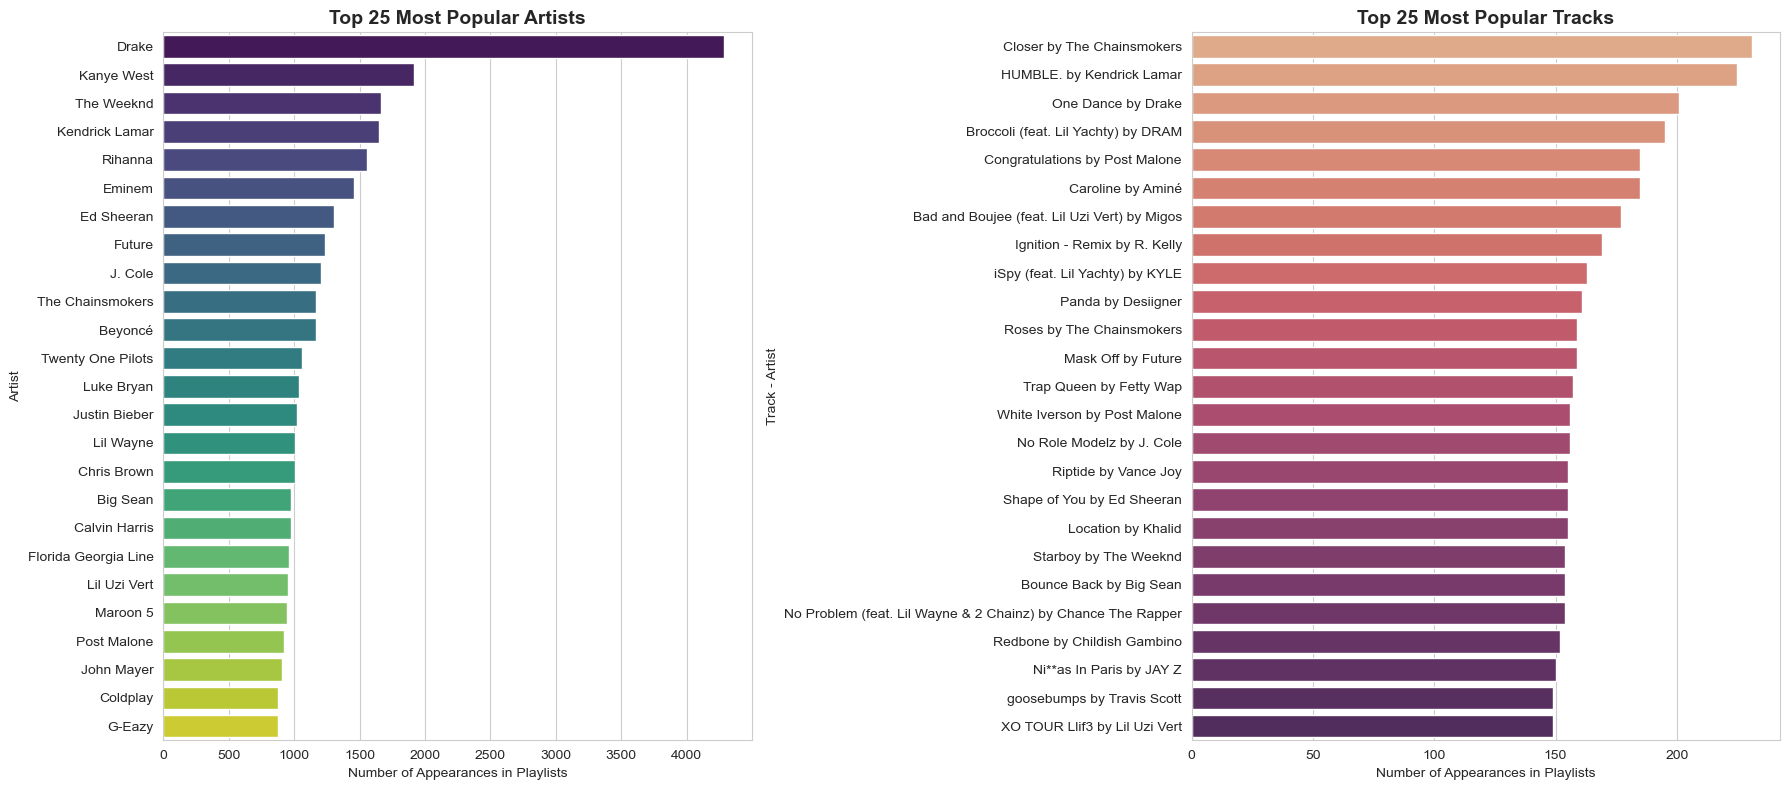

In [ ]:
# Just like before 
sns.set_style("whitegrid")

# For both of these graphics we will be using track information.

# The dataframe that we define is for the trop artist's, where we  count how many times each artist appears across all playlists
Top_Aritists_DataFrame = (
    playlist_track_DataFrame_5k.groupBy("artist_name") # so we group by the artist's name 
    .count() # we count them up 
    .orderBy(functions.col("count").desc()) # we order in a descending manner  
    .limit(25) # Doing trop 25 seems to be reasonable without being too excessive  
    .toPandas()
    )

# For the top tracks we shall be suing the playlist_track_DataFrame_5k dataframe.
# This wil be grouped by both track and artist to avoid problems with the way the data are encoded (if we didn't do this we had weird results)

Top_Tracks_DataFrame =(
    playlist_track_DataFrame_5k.groupBy("track_name", "artist_name")  
    .count() # same logic as the previous dataframe 
    .orderBy(functions.col("count").desc()) 
    .limit(25) 
    .toPandas()
    )

# Here we create labels to get the title of the Song "by" name of the artist
Top_Tracks_DataFrame["label"] = Top_Tracks_DataFrame["track_name"] + " by " + Top_Tracks_DataFrame["artist_name"]

# Same visualization just like the previous cells but here we use color pallets instead of one one color to signi

figure, axes = plt.subplots(1, 2, figsize=(18, 8))

# Left top 25 artists plot 
sns.barplot(
    data=Top_Aritists_DataFrame,x="count",y="artist_name",hue="artist_name",      
    dodge=False, palette="viridis",legend=False,ax=axes[0]
)

axes[0].set_title("Top 25 Most Popular Artists", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Number of Appearances in Playlists")
axes[0].set_ylabel("Artist")

# Right top 25 tracks plot  
sns.barplot(
    data=Top_Tracks_DataFrame, x="count", y="label",hue="label",            
    dodge=False, palette="flare", legend=False,ax=axes[1]
)

axes[1].set_title("Top 25 Most Popular Tracks", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Number of Appearances in Playlists")
axes[1].set_ylabel("Track - Artist")

plt.tight_layout()
plt.show()

#### 2.3.4  Year by year distribution of playlists (2011–2017)

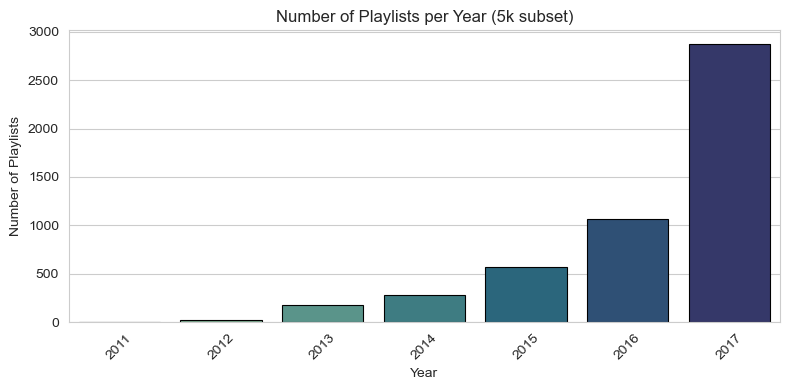

In [ ]:
# Just like before
sns.set_style("whitegrid")

# Here we ake a dataframe using playlists_flat_DataFrame_5k to contain relevant year information, since the majority of the data comes from 2017 as the graph shows.
DataFrame_Playlists_Years = (
    playlists_flat_DataFrame_5k
    .withColumn("year", functions.year(functions.from_unixtime("modified_at"))) # here we make a new column year, which is created from the unix stamp modified_at into a datatime value 
    .groupBy("year") # than we group by tis new column 
    .agg(functions.count("*").alias("number_of_playlists")) # here we aggregate on each year, where we count each row "*" for that particular year and we rename it to number_of_playlists
    .orderBy("year") # than we order by year, so into a chronological ascending way 
    .toPandas() # convert to Pandas 
)

# Same as before with sns 
plt.figure(figsize=(8, 4))

plot_of_Years = sns.barplot(
    data=DataFrame_Playlists_Years,
    x="year",
    y="number_of_playlists",
    hue="year", 
    palette="crest", # here we opted for a platte coloring than a single color 
    dodge=False,
    legend=False,
    edgecolor="black",  
    linewidth=0.8       
)

# Using Plt to complete the plot 
plt.title("Number of Playlists per Year (5k subset)")
plt.xlabel("Year")
plt.ylabel("Number of Playlists")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


#### `50k_Playlists`


#### 2.3.1 Distribution of playlist length and track frequency


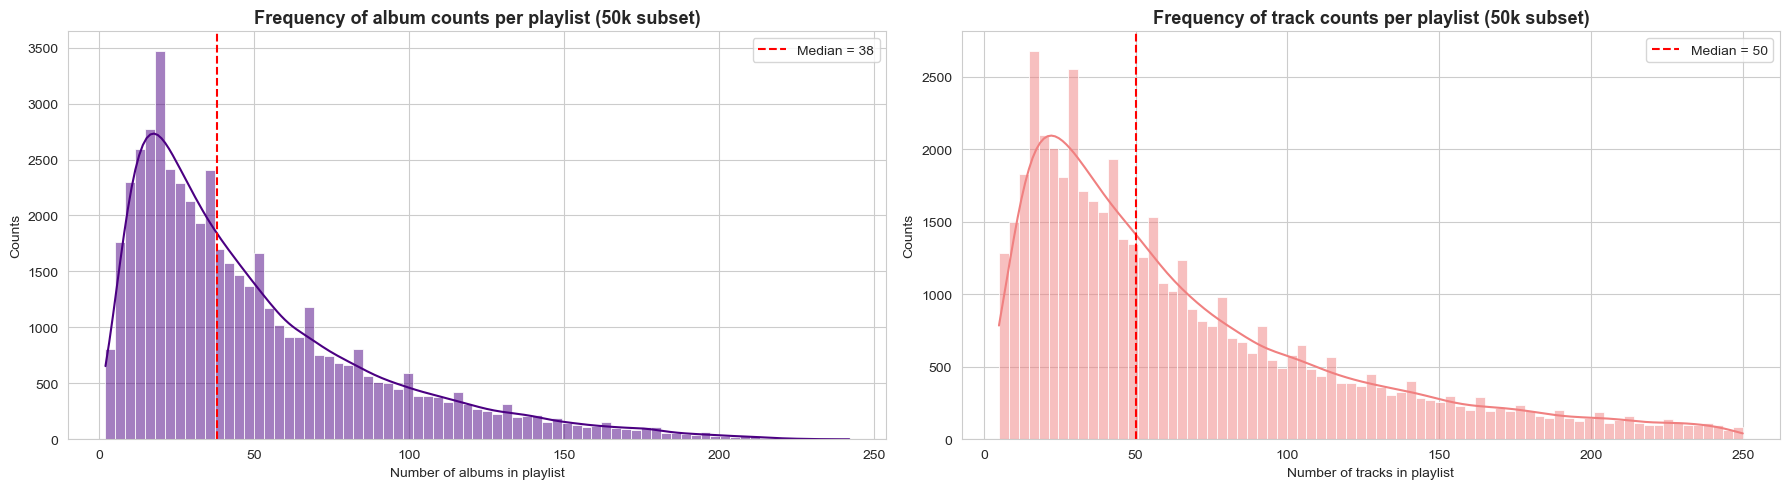

In [ ]:

# This will be an universal theme, the graphics look better with a white grid pattern as background 
sns.set_style("whitegrid")

# --- Step 1: Spark → Pandas with just what we need ---
# Here we use Spark to select only the num_tracks and num_albums columns from our playlists_flat_DataFrame_50k dataframe 
# And importantly convert this to a Pandas dataframe which Seahorse does very much like. 
# Additionally, the majority of the plotting for Task 2 will be one using Seahorse.

playlist_DataFrame_generic_infos = (playlists_flat_DataFrame_50k
    .select("num_tracks", "num_albums")
    .toPandas()) 

# Adding the median value is a nice touch in the graphic, not the mean since this could be affected by outliers 
tracks_median = playlist_DataFrame_generic_infos["num_tracks"].median()
albums_median = playlist_DataFrame_generic_infos["num_albums"].median()

# This first cell is meant to show the country / frequency distribution of "num_tracks" and "num_albums"
# For this we initialize two subplots using Matplotlib but the actual plotting is done by sns. 

figure, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.histplot(data=playlist_DataFrame_generic_infos,
    x="num_albums",
    bins=75, # This is a arbitrary but 25 seems to produce a correct distribution graphic 
    kde=True, # We add a smooth curve on top of histogram
    ax=axes[0],
    color="#4B0082") # All the colors were chosen using an RGB pallette website 

# Here we added the Median vertical line 
axes[0].axvline(albums_median, color="#FF0000", linestyle="--",label=f"Median = {albums_median:.0f}")

# The rest is mainly graphic annotation:
axes[0].set_title("Frequency of album counts per playlist (50k subset)", fontsize=13, fontweight="bold")
axes[0].set_xlabel("Number of albums in playlist")
axes[0].set_ylabel("Counts")
axes[0].legend()

# Here we have the same logic for the 2nd histogram for tracks 
sns.histplot(
    data=playlist_DataFrame_generic_infos,
    x="num_tracks",
    bins=75,
    kde=True,
    ax=axes[1],
    color="#F08080")

axes[1].axvline(tracks_median, color="#FF0000", linestyle="--",label=f"Median = {tracks_median:.0f}")
axes[1].set_title("Frequency of track counts per playlist (50k subset)", fontsize=13, fontweight="bold")
axes[1].set_xlabel("Number of tracks in playlist")
axes[1].set_ylabel("Counts")
axes[1].legend()

plt.tight_layout()
plt.show()


#### 2.3.2 Distribution of playlist size and diversity


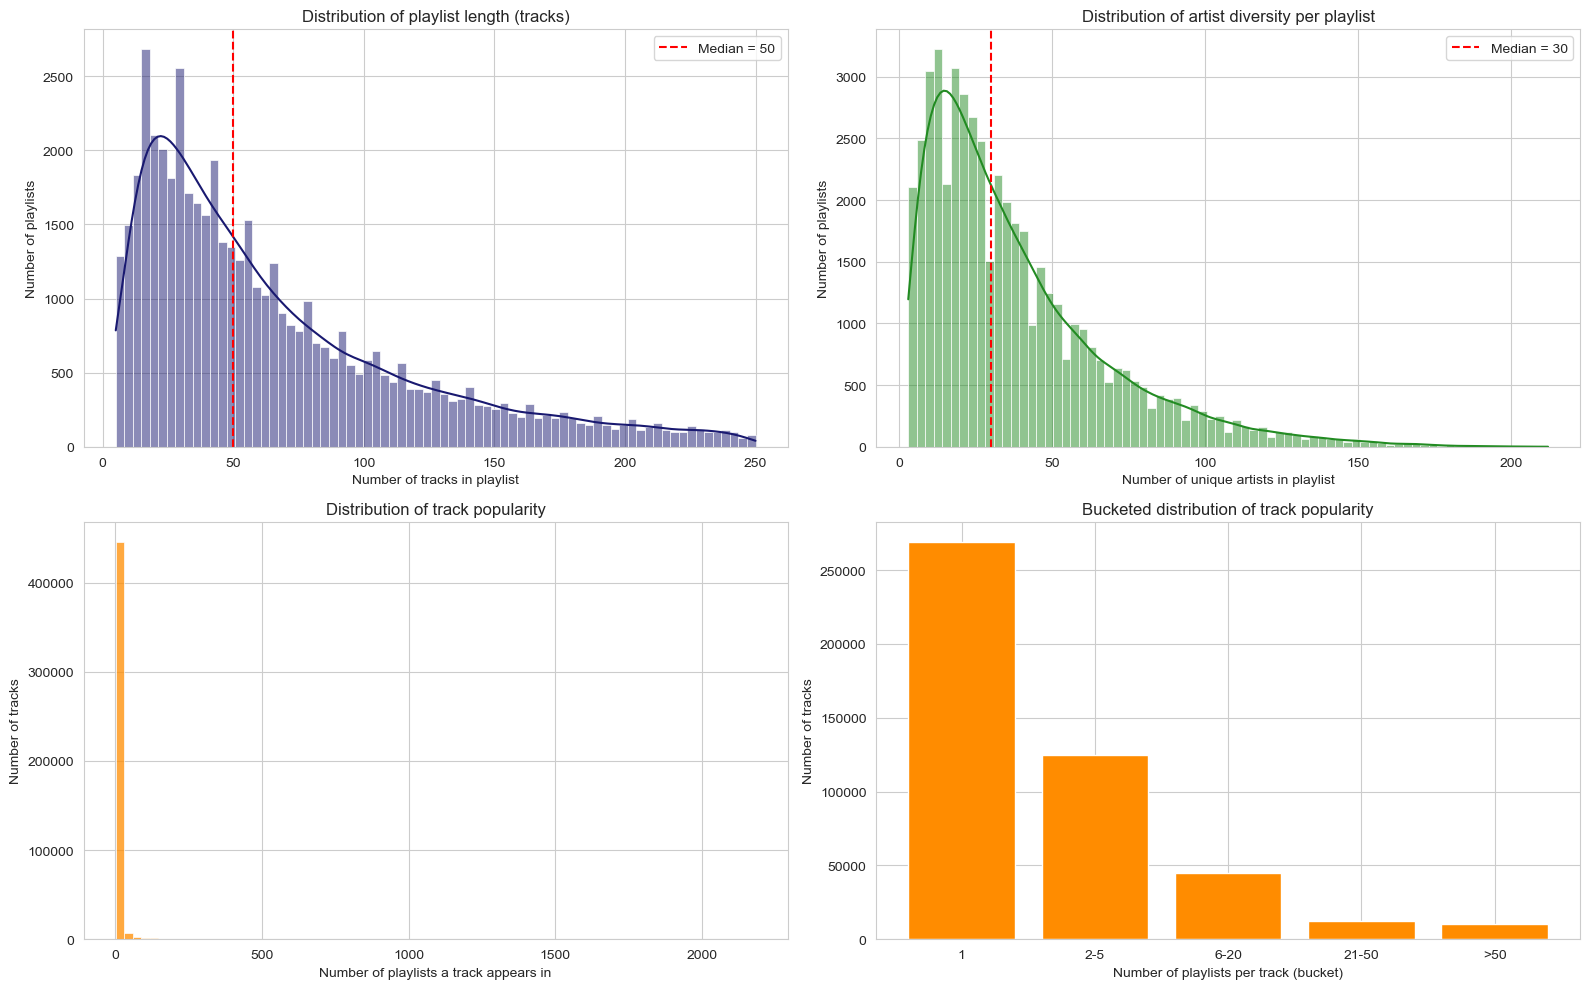

In [ ]:
# Just like before 
sns.set_style("whitegrid")

# Here we shall make the dataframes which contain the "playlist" interesting plotting wise information:
# So the upper graphics:

# Here we take the playlist table, and select the pid and num_tracks which we need to plot the distribution of playlist lengths (number of tracks per playlist) in the upper-left panel
# The reason we keep pid is that it's going to be used for mergning the final Pandas dataframe. 
playlist_informations = (playlists_flat_DataFrame_50k
    .select("pid", "num_tracks")
    )

# Than from the track table, we group by PID so group rows by playlist ID's (`pid`), than we count the unique artist ID's (`artist_uri`)
# , and at the end we rename into number_of_unique_artists

artist_diversity_from_track_information = (playlist_track_DataFrame_50k
    .groupBy("pid").agg(functions.countDistinct("artist_uri").alias("number_of_unique_artists"))
)

# Here we just merge using .join using the pid, here we do an inner join to keep all the relevant information for the final Pandas dataframe 
DataFrame_for_Playlist_plotting = (
    playlist_informations
    .join(artist_diversity_from_track_information, on="pid", how="inner")
    .toPandas()
)

# Just like in the previous code cell we compute medians
tracks_median  = DataFrame_for_Playlist_plotting["num_tracks"].median()
artists_median = DataFrame_for_Playlist_plotting["number_of_unique_artists"].median()

# Here we shall make the dataframes which contain the "track" interesting plotting wise information:
# So the lower graphics:

# Here we do not need to merge two different tables, since all the relevant information are present in the track table
# So we just group_by track_uri and aggregate using pid, which we than can just transform into a Pandas table 
DataFrame_for_Track_plotting = (
    playlist_track_DataFrame_50k
    .groupBy("track_uri")
    .agg(functions.countDistinct("pid").alias("num_playlists_per_track"))
    .toPandas()
)

# Here we create the different bins since, the continuous graphic will be mainly centered around the value of 1
# THe 2184 which is the max value of "num_playlists_per_track" +1 so we capture all the values present in this column.
bins_that_we_will_use   = [1, 2, 6, 21, 51,2184]

# Here we make 5 catagorical labels, these 5 seem to be enough to spread out the data accordingly 
labels = ["1", "2-5", "6-20", "21-50", ">50"]

# Here Use pd.cut to assign each track a bucket value in the DataFrame_for_Track_plotting dataframe 

DataFrame_for_Track_plotting["bucket_values"] = pd.cut(
    DataFrame_for_Track_plotting["num_playlists_per_track"],
    bins=bins_that_we_will_use,
    right=False,
    labels=labels
)

# Simply we just count how many tracks fall in each bucket category then we sort them by order 
bucket_counts = (
    DataFrame_for_Track_plotting["bucket_values"]
    .value_counts() # So here counts(), counts by the 5 categories labels that we made  
    .sort_index() # we index so we have the right order 
)

# Plotting just like in the cell above:

figures, axes = plt.subplots(2, 2, figsize=(16, 10))

# Here we plot the upper left playlist length and median value 
sns.histplot(
    DataFrame_for_Playlist_plotting["num_tracks"],
    bins=75,
    kde=True,
    ax=axes[0, 0],
    color="#191970"
)

axes[0, 0].axvline(tracks_median,color="#FF0000",linestyle="--",linewidth=1.5,label=f"Median = {tracks_median:.0f}")
axes[0, 0].set_title("Distribution of playlist length (tracks)")
axes[0, 0].set_xlabel("Number of tracks in playlist")
axes[0, 0].set_ylabel("Number of playlists")
axes[0, 0].legend()

# Here we have the upper right graph, for artist diversity and median
sns.histplot(
    DataFrame_for_Playlist_plotting["number_of_unique_artists"],
    bins=75,
    kde=True,
    ax=axes[0, 1],
    color="#228B22"
)

axes[0, 1].axvline(artists_median,color="#FF0000",linestyle="--",linewidth=1.5,label=f"Median = {artists_median:.0f}")
axes[0, 1].set_title("Distribution of artist diversity per playlist")
axes[0, 1].set_xlabel("Number of unique artists in playlist")
axes[0, 1].set_ylabel("Number of playlists")
axes[0, 1].legend()

# Lower left graphic which ist he continuous track popularity
sns.histplot(
    DataFrame_for_Track_plotting["num_playlists_per_track"],
    bins=75,
    kde=False,
    ax=axes[1, 0],
    color="#FF8C00"
)

axes[1, 0].set_title("Distribution of track popularity")
axes[1, 0].set_xlabel("Number of playlists a track appears in")
axes[1, 0].set_ylabel("Number of tracks")
# This technically would simpler to visualize in log or ln transformation 
# But we want to keep it this way since we are doing the categorical breakdown just beside 

# And finally we have the lower right categorical track popularity
axes[1, 1].bar(
    bucket_counts.index.astype(str),
    bucket_counts.values,
    color="#FF8C00"
)

axes[1, 1].set_title("Bucketed distribution of track popularity")
axes[1, 1].set_xlabel("Number of playlists per track (bucket)")
axes[1, 1].set_ylabel("Number of tracks")

plt.tight_layout()
plt.show()



#### 2.3.3 Most frequent artists and tracks in the 50k subset

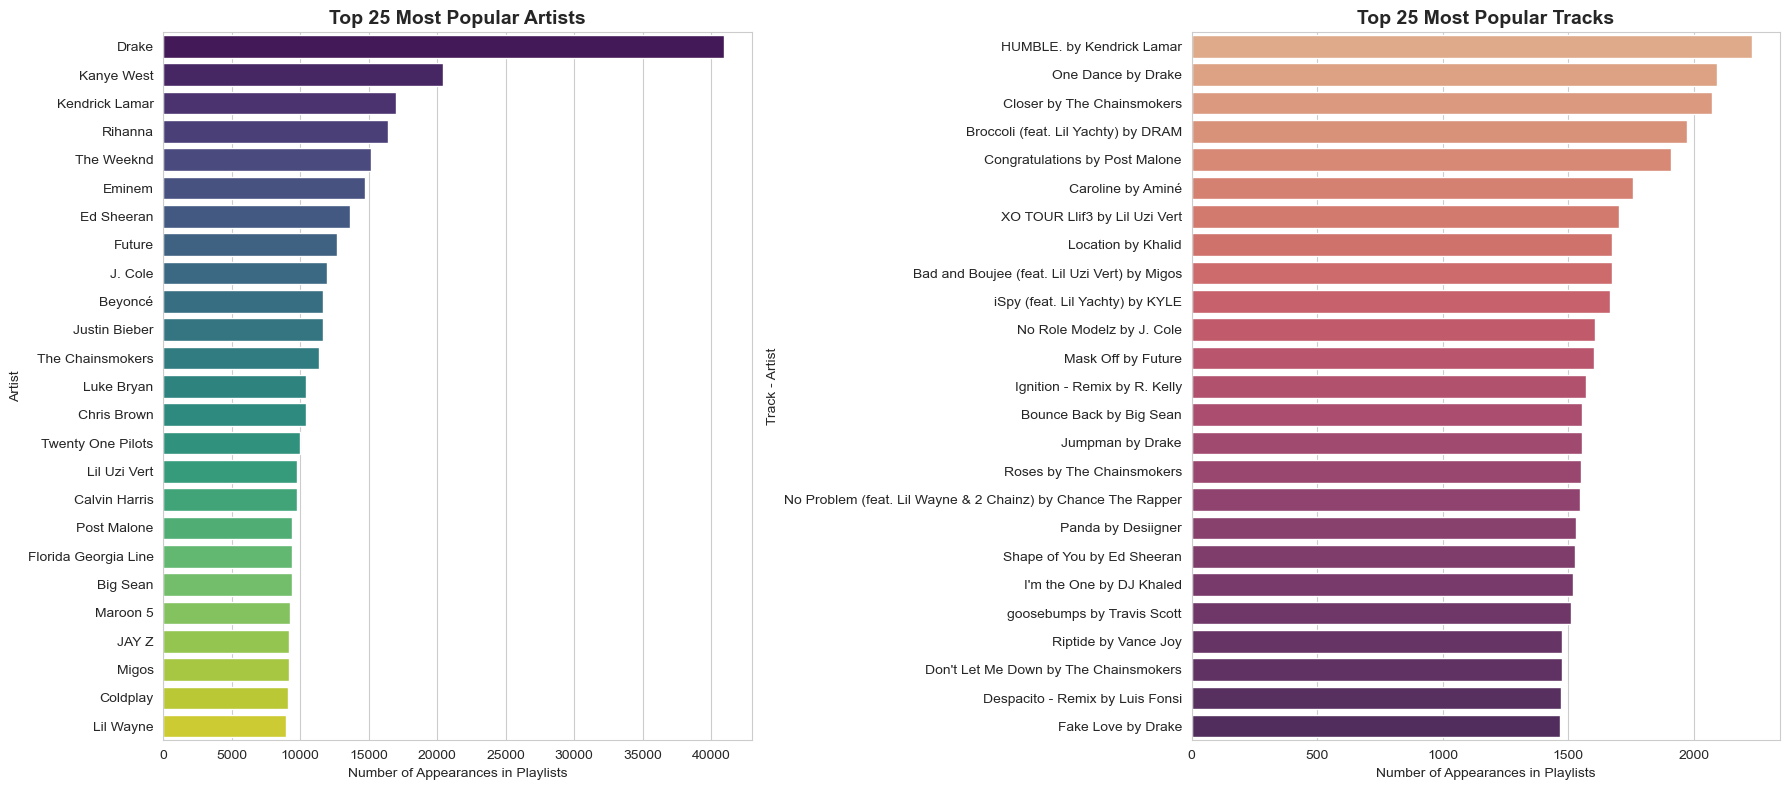

In [ ]:
# Just like before 
sns.set_style("whitegrid")

# For both of these graphics we will be using track information.

# The dataframe that we define is for the trop artist's, where we  count how many times each artist appears across all playlists
Top_Aritists_DataFrame = (
    playlist_track_DataFrame_50k.groupBy("artist_name") # so we group by the artist's name 
    .count() # we count them up 
    .orderBy(functions.col("count").desc()) # we order in a descending manner  
    .limit(25) # Doing trop 25 seems to be reasonable without being too excessive  
    .toPandas()
    )

# For the top tracks we shall be suing the playlist_track_DataFrame_50k dataframe.
# This wil be grouped by both track and artist to avoid problems with the way the data are encoded (if we didn't do this we had weird results)

Top_Tracks_DataFrame =(
    playlist_track_DataFrame_50k.groupBy("track_name", "artist_name")  
    .count() # same logic as the previous dataframe 
    .orderBy(functions.col("count").desc()) 
    .limit(25) 
    .toPandas()
    )

# Here we create labels to get the title of the Song "by" name of the artist
Top_Tracks_DataFrame["label"] = Top_Tracks_DataFrame["track_name"] + " by " + Top_Tracks_DataFrame["artist_name"]

# Same visualization just like the previous cells but here we use color pallets instead of one one color to signi

figure, axes = plt.subplots(1, 2, figsize=(18, 8))

# Left top 25 artists plot 
sns.barplot(
    data=Top_Aritists_DataFrame,x="count",y="artist_name",hue="artist_name",      
    dodge=False, palette="viridis",legend=False,ax=axes[0]
)

axes[0].set_title("Top 25 Most Popular Artists", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Number of Appearances in Playlists")
axes[0].set_ylabel("Artist")

# Right top 25 tracks plot  
sns.barplot(
    data=Top_Tracks_DataFrame, x="count", y="label",hue="label",            
    dodge=False, palette="flare", legend=False,ax=axes[1]
)

axes[1].set_title("Top 25 Most Popular Tracks", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Number of Appearances in Playlists")
axes[1].set_ylabel("Track - Artist")

plt.tight_layout()
plt.show()

#### 2.3.4  Year by year distribution of playlists (2011–2017)

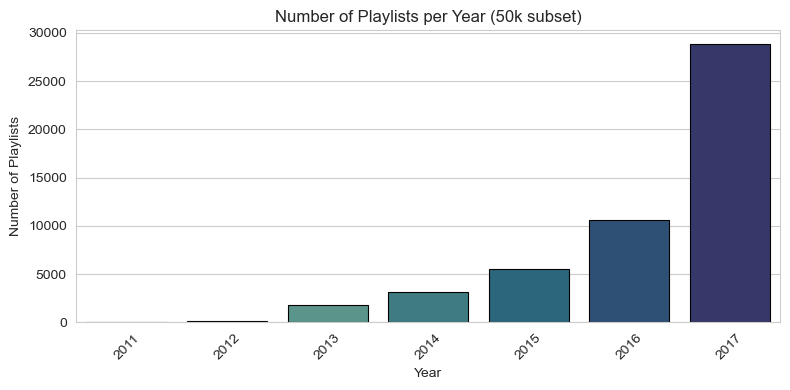

In [ ]:
# Just like before
sns.set_style("whitegrid")

# Here we ake a dataframe using playlists_flat_DataFrame_50k to contain relevant year information, since the majority of the data comes from 2017 as the graph shows.
DataFrame_Playlists_Years = (
    playlists_flat_DataFrame_50k
    .withColumn("year", functions.year(functions.from_unixtime("modified_at"))) # here we make a new column year, which is created from the unix stamp modified_at into a datatime value 
    .groupBy("year") # than we group by tis new column 
    .agg(functions.count("*").alias("number_of_playlists")) # here we aggregate on each year, where we count each row "*" for that particular year and we rename it to number_of_playlists
    .orderBy("year") # than we order by year, so into a chronological ascending way 
    .toPandas() # convert to Pandas 
)

# Same as before with sns 
plt.figure(figsize=(8, 4))

plot_of_Years = sns.barplot(
    data=DataFrame_Playlists_Years,
    x="year",
    y="number_of_playlists",
    hue="year", 
    palette="crest", # here we opted for a platte coloring than a single color 
    dodge=False,
    legend=False,
    edgecolor="black",  
    linewidth=0.8       
)

# Using Plt to complete the plot 
plt.title("Number of Playlists per Year (50k subset)")
plt.xlabel("Year")
plt.ylabel("Number of Playlists")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


---

# Task 3: 

In [ ]:
# Reuse DataFrames from the universal loader (Task 2)
playlists_flat_DataFrame = playlists_flat_DataFrame_5k
playlist_track_DataFrame = playlist_track_DataFrame_5k

## 3.1 Building the (Playlist, Track) relation and filtering tracks.
#### This block is preparing the core dataset needed for the co-occurence analysis by constructing a clean (pid, track_uri) relationand reducing it to a manageable subset of tracks.

In [ ]:
from pyspark.sql import functions as F

# build (playlist, track) relation. Only the playlist ID and track URI are kept. 
track_in_playlists = playlist_track_DataFrame.select("pid", "track_uri").distinct()
track_in_playlists.show(5, truncate=False)

# per-track playlist counts
track_playlist_counts = (
    track_in_playlists
    .groupBy("track_uri")
    .agg(F.countDistinct("pid").alias("playlist_count"))
)

track_playlist_counts.show(5, truncate=False)

# Keep tracks appearing in >= 2 playlists, popular tracks) (so that it is more digestible for my laptop to run, and spark does not crash)
popular_track_uris = (
    track_playlist_counts
    .filter(F.col("playlist_count") >= 2)
    .select("track_uri")
)

# Reconstruct the filtered incidence relation.
track_in_playlists_pop = (
    track_in_playlists
    .join(popular_track_uris, on="track_uri")
    .cache()
)

track_in_playlists_pop.count()


+----+------------------------------------+
|pid |track_uri                           |
+----+------------------------------------+
|4000|spotify:track:6NGxGmKo0w0zQE9HuaKzd9|
|4003|spotify:track:7FrPSk0rZdCPR50pfzdzMK|
|4003|spotify:track:5HRcFL5LZb6PoE17CDNTU0|
|4008|spotify:track:2zcps4ZXVu0tN1uAKcQRqg|
|4008|spotify:track:0qHVFGgYU93vZOj17MHIhd|
+----+------------------------------------+
only showing top 5 rows


+------------------------------------+--------------+
|track_uri                           |playlist_count|
+------------------------------------+--------------+
|spotify:track:6ltPEsP4edATzvinHOzvk2|59            |
|spotify:track:35k31HZI4z9PbBOioaI4dZ|24            |
|spotify:track:5G1RhMTSAzFSmTkeUbKlBF|6             |
|spotify:track:2x7cxHkkKF4afADOkrxe6J|4             |
|spotify:track:61xW0GqeX38uF0elO3jjql|2             |
+------------------------------------+--------------+
only showing top 5 rows


257548

## 3.1.1 Optional sampling step (to limit analysis to top-N most frequent tracks)

In [ ]:
# Take only first N tracks for a test run (e.g. 500 tracks)
# this is because my laptop cannot run the pop subset
# remove / comment out for submission or if you can run larger set

subset_tracks = (
    track_playlist_counts
    .orderBy(F.desc("playlist_count"))
    .limit(500)              # adjust as needed (smaller = safer)
    .select("track_uri")
)

# Restrict the (playlist, track) relation to only those top-N tracks

track_in_playlists_sub = (
    track_in_playlists
    .join(subset_tracks, on="track_uri")
    .cache()
)
track_in_playlists_sub.count()


41783

## 3.2 Co-Occurence on a filtered (Playlist, Track) table
#### Here I use track_in_playlists_sub as an example, but any similar (playlist, track) table can be substituted.

In [ ]:
incidence_df = track_in_playlists_sub  # or track_in_playlists_pop

track_cooccurrences = (
    incidence_df.alias("a")
    .join(incidence_df.alias("b"), on="pid")
    .where(F.col("a.track_uri") < F.col("b.track_uri"))  # avoid duplicates & self-track_cooccurrences
    .groupBy(
        F.col("a.track_uri").alias("track_a"),
        F.col("b.track_uri").alias("track_b")
    )
    .agg(F.count("*").alias("cooc_count"))
)

track_cooccurrences.show(5, truncate=False)


+------------------------------------+------------------------------------+----------+
|track_a                             |track_b                             |cooc_count|
+------------------------------------+------------------------------------+----------+
|spotify:track:0v9Wz8o0BT8DU38R4ddjeH|spotify:track:1yxgsra98r3qAtxqiGZPiX|13        |
|spotify:track:04KTF78FFg8sOHC1BADqbY|spotify:track:0LWQWOFoz5GJLqcHk1fRO2|10        |
|spotify:track:4qikXelSRKvoCqFcHLB2H2|spotify:track:7jslhIiELQkgW9IHeYNOWE|6         |
|spotify:track:1jNOi6m3Hn8nLEeHCp5Msr|spotify:track:2aibwv5hGXSgw7Yru8IYTO|6         |
|spotify:track:0KKkJNfGyhkQ5aFogxQAPU|spotify:track:6JV2JOEocMgcZxYSZelKcc|15        |
+------------------------------------+------------------------------------+----------+
only showing top 5 rows


## 3.3 Computing Cosine Similarity between track pairs.
#### This metric rescales the raw co-occurence counts so that similarity is not dominated by globally popular tracks. It measures how unexpectedly often two tracks appear together relative to how often they appear overall. This will produce a normalised track-track similarity.

In [ ]:
# Create two renamed copies of the per-track playlist-count table. 

track_playlist_counts_a = (
    track_playlist_counts
    .withColumnRenamed("track_uri", "track_a")  # rename for joining on 'track_a'
    .withColumnRenamed("playlist_count", "count_a")  # number of playlists containing track_a
)

track_playlist_counts_b = (
    track_playlist_counts
    .withColumnRenamed("track_uri", "track_b") # rename for joining on 'track_b'
    .withColumnRenamed("playlist_count", "count_b") # number of playlists containing track_b
)

# Combine co-occurrence counts with the popularity counts of track_a and track_b,
# for computing cosine similarity between the two tracks based on:

track_similarity = (
    track_cooccurrences
    .join(track_playlist_counts_a, on="track_a")         
    .join(track_playlist_counts_b, on="track_b")          
    .withColumn(
        "cosine_cooc",
        F.col("cooc_count") /  # numerator: shared playlists
        F.sqrt(F.col("count_a") * F.col("count_b")) # denominator: geometric mean of their frequencies
    )
)

# inspection of the top-similar track pairs. Which pairs have the highest similarity?
track_similarity.orderBy(F.desc("cosine_cooc")).show(20, truncate=False)

+------------------------------------+------------------------------------+----------+-------+-------+------------------+
|track_b                             |track_a                             |cooc_count|count_a|count_b|cosine_cooc       |
+------------------------------------+------------------------------------+----------+-------+-------+------------------+
|spotify:track:2ANLarE8yHVsLWW21nj79M|spotify:track:0B8QzDH7YWih85V5SEMnyJ|57        |87     |97     |0.620482249978366 |
|spotify:track:5HGibWoxnkYSkl6mHmAlOE|spotify:track:03fT3OHB9KyMtGMt2zwqCT|56        |105    |78     |0.6187939745230095|
|spotify:track:5kjyiH6but1t2UDXq15aeS|spotify:track:1yEwEiTpsaPhQi9lb5EVV4|45        |78     |70     |0.6089984572058625|
|spotify:track:4dGJf1SER1T6ooX46vwzRB|spotify:track:1yEwEiTpsaPhQi9lb5EVV4|57        |78     |113    |0.6071392818424457|
|spotify:track:6fwdbPMwP1zVStm8FybmkO|spotify:track:4gmmRb6bZJffOOiww1JGTO|52        |72     |107    |0.5924411367547081|
|spotify:track:6s9ICeczY

## 3.4 Adding track metadata
#### This just helps with interpretation and makes the outputs easier to inspect.

In [ ]:
# Join back names for a nicer interpretation
# Build a small “dictionary” track_uri → (name, artist) metadata table

track_meta = (
    playlist_track_DataFrame
    .select("track_uri", "track_name", "artist_name")
    .dropna(subset=["track_uri"])
    .dropDuplicates(["track_uri"])
)

#   - dropna ensures no null URIs are included.
#   - dropDuplicates ensures exactly one row per track_uri.

# Join metadata to the cosine similarity matrix
similarity_with_metadata = (
    track_similarity
    .join(track_meta.withColumnRenamed("track_uri", "track_a"), on="track_a")
    .withColumnRenamed("track_name", "track_a_name")
    .withColumnRenamed("artist_name", "artist_a_name")
    .join(track_meta.withColumnRenamed("track_uri", "track_b"), on=("track_b"))
    .withColumnRenamed("track_name", "track_b_name")
    .withColumnRenamed("artist_name", "artist_b_name")
)

# Display highest-scoring track pairs with names for interpretation
similarity_with_metadata.orderBy(F.desc("cosine_cooc")).show(20, truncate=False)

+------------------------------------+------------------------------------+----------+-------+-------+------------------+------------------------------------------------------+----------------------------+-----------------------+----------------------------+
|track_b                             |track_a                             |cooc_count|count_a|count_b|cosine_cooc       |track_a_name                                          |artist_a_name               |track_b_name           |artist_b_name               |
+------------------------------------+------------------------------------+----------+-------+-------+------------------+------------------------------------------------------+----------------------------+-----------------------+----------------------------+
|spotify:track:2ANLarE8yHVsLWW21nj79M|spotify:track:0B8QzDH7YWih85V5SEMnyJ|57        |87     |97     |0.620482249978366 |Money Longer                                          |Lil Uzi Vert                |You Was Right     

## 3.5 Query most similar tracks to a given target
####  Given a target track (identified by its URI), retrieve the top-k tracks that are most similar to it according to the cosine-based co-occurrence similarity.

In [ ]:
# Method:
#
# 1. Filter similarity_with_metadata to retain only track-pairs in which the
#    target track participates. Each row represents a co-occurring pair: (track_a, track_b)
#      
#     We keep rows where: track_a == target_uri   OR   track_b == target_uri
#
# 2. For each of these rows, derive which track is the *other* track in the pair. Only one of the two 
#    columns equals the target track; the other is the candidate recommendation.
#      - other_track_uri  = the non-target track
#      - other_track_name / other_artist_name = matched metadata
#
#   3. Select the relevant columns for output:
#      * other_track_uri, other_track_name, other_artist_name
#      * cosine_cooc  (cosine similarity score)
#      *  cooc_count   (raw number of shared playlists)
#
#   4. Rank all candidate tracks by cosine similarity and return the top-k.

def most_similar_tracks(target_uri, k=10):
    """
    Print top-k tracks most similar to `target_uri` based on cosine_cooc.
    Uses the similarity_with_metadata DataFrame.
    """

    sims = (
        similarity_with_metadata
        # Keep only rows where the target appears in the pair.
        .filter(
            (F.col("track_a") == target_uri) |
            (F.col("track_b") == target_uri)
        )
        .withColumn(
            "other_track_uri", # identify the other track's URI
            F.when(F.col("track_a") == target_uri, F.col("track_b"))
             .otherwise(F.col("track_a"))
        )
        .withColumn(
            "other_track_name", # identify the other track's name
            F.when(F.col("track_a") == target_uri, F.col("track_b_name"))
             .otherwise(F.col("track_a_name"))
        )
        .withColumn(
            "other_artist_name", # identify the other artist's name
            F.when(F.col("track_a") == target_uri, F.col("artist_b_name"))
             .otherwise(F.col("artist_a_name"))
        )
        .select(
            "other_track_uri",
            "other_track_name",
            "other_artist_name",
            "cosine_cooc",
            "cooc_count",
        )
        .orderBy(F.desc("cosine_cooc")) # sort by similarity score and keep top-k
        .limit(k)
    )

    sims.show(truncate=False)


In [ ]:
# for example, pick one of the subset tracks  used earlier
# if you did not use the subset, skip this code block and run the next block below which I have commented out:

example_uri = subset_tracks.first()["track_uri"]
print(example_uri)

most_similar_tracks(example_uri, k=10)

# example_uri = track_in_playlists_pop.select("track_uri").first()["track_uri"]
# print("Example track URI:", example_uri)
# most_similar_tracks(example_uri, k=10)



spotify:track:7BKLCZ1jbUBVqRi2FVlTVw


+------------------------------------+-------------------------------------+-----------------+-------------------+----------+
|other_track_uri                     |other_track_name                     |other_artist_name|cosine_cooc        |cooc_count|
+------------------------------------+-------------------------------------+-----------------+-------------------+----------+
|spotify:track:6DNtNfH8hXkqOX1sjqmI7p|Cold Water (feat. Justin Bieber & MØ)|Major Lazer      |0.42948826719817906|70        |
|spotify:track:4pdPtRcBmOSQDlJ3Fk945m|Let Me Love You                      |DJ Snake         |0.4097075322821556 |62        |
|spotify:track:6875MeXyCW0wLyT72Eetmo|Starving                             |Hailee Steinfeld |0.4087084100217135 |59        |
|spotify:track:0QsvXIfqM0zZoerQfsI9lm|Don't Let Me Down                    |The Chainsmokers |0.38829712917457143|71        |
|spotify:track:2rizacJSyD9S1IQUxUxnsK|All We Know                          |The Chainsmokers |0.32214906772185625|39  

---

# Task 4:



### Playlist similarity (0–1)

The goal of Task 4 is to define a similarity score between two playlists, ranging from 0 to 1 (borns included) where 0 means the playlists have nothing in common (following our metrics) and 1 that they are identical. This method will be later used as part of the final method to solve the Million Playlist Dataset problem.

In our implementation, the playlist similarity score is defined as a weighted combination of:
- Overlap (Jaccard/Tanimoto) similarity score : average Jaccard/Tanimoto similarity between the two playlists's respective : tracks, albums, and artists sets.
- Composition (TF-IDF cosine) : average cosine similarity of TF-IDF vectors built from both artists and albums, where the IDF is computed globally over playlists (smoothed IDF Formula used : $log((N+1)/(df+1)) + 1$).

The final playlist similarity score formula is :
$$
S = w_{overlap}\,S_{overlap} + w_{comp}\,S_{comp} \quad \in [0,1]
$$

Please find references and more informations in the written report.

In [ ]:
from pyspark.sql import functions as F              
from pyspark.sql import DataFrame, SparkSession     
from typing import Tuple, Dict                      
import math                                         


def collect_term_set(pt: DataFrame, pid: int, col: str) -> set:
    """Returns the distinct set of values of `col` for playlist pid."""
    # Filter to one playlist, select one column, deduplicate, then collect values to the driver.
    # Note: .collect() brings data to the driver (OK if playlists are small).
    return set(
        pt.filter(F.col("pid") == pid)
          .select(col)
          .distinct()
          .rdd
          .flatMap(lambda r: r)   # Row -> value (single-column row)
          .collect()
    )


def jaccard_between_sets(a: set, b: set) -> float:
    """Jaccard |A∩B| / (|A| + |B| - |A∩B|). Handles empty-set cases."""
    # Note : if both sets are empty, similarity is 0.0
    if not a or not b:
        return 0.0
    inter = len(a & b)
    denom = len(a) + len(b) - inter
    return float(inter) / denom


def compute_idf(track_df: DataFrame, term_col: str = "artist_uri", pid_col: str = "pid") -> DataFrame:
    # N = number of distinct playlists (documents)
    N = track_df.select(pid_col).distinct().count()

    # df(term) = number of distinct playlists that contain the term
    # - select(term, pid)
    # - distinct() so a (term, pid) pair is counted once
    # - groupBy(term) and countDistinct(pid)
    df_df = (
        track_df.select(term_col, pid_col)
                .distinct()
                .groupBy(term_col)
                .agg(F.countDistinct(pid_col).alias("df"))
    )

    # Smoothed IDF (common variant): log((N+1)/(df+1)) + 1
    idf_df = (
        df_df.withColumn(
            "idf",
            F.log((F.lit(float(N) + 1.0) / (F.col("df") + F.lit(1.0)))) + F.lit(1.0),
        )
        .select(term_col, "idf")
    )
    return idf_df


def tfidf_vector_for_playlist(
    pt: DataFrame,
    pid: int,
    term_col: str,
    idf_df: DataFrame
) -> Tuple[Dict[str, float], float]:
    """
    Computes the TF-IDF vector for a playlist (returns dict term->tfidf and the L2 norm).
    We collect the small vector on the driver side (playlists are small).
    """
    # TF(term) within the playlist pid
    tf_df = (
        pt.filter(F.col("pid") == pid)
          .groupBy(term_col)
          .agg(F.count("*").alias("tf"))
    )

    # Join TF with global IDF for those terms; missing IDF -> 0.0
    tfidf_df = tf_df.join(idf_df, on=term_col, how="left").fillna(0.0, subset=["idf"])

    # TF-IDF weight
    tfidf_df = tfidf_df.withColumn("tfidf", F.col("tf") * F.col("idf"))

    # Bring the sparse vector to the driver as a list of (term, tfidf)
    rows = (
        tfidf_df.select(term_col, "tfidf")
                .rdd
                .map(lambda r: (r[0], float(r[1])))
                .collect()
    )

    # Convert to a Python dict for fast sparse operations
    vec = {r[0]: r[1] for r in rows}

    # L2 norm for cosine similarity
    norm = math.sqrt(sum(v * v for v in vec.values())) if vec else 0.0
    return vec, norm


def cosine_between_dicts(
    vec_a: Dict[str, float],
    norm_a: float,
    vec_b: Dict[str, float],
    norm_b: float
) -> float:
    # If one vector is empty (norm 0), cosine similarity is defined as 0 here
    if norm_a == 0.0 or norm_b == 0.0:
        return 0.0

    # Iterate over the smaller dict for efficiency
    if len(vec_a) > len(vec_b):
        vec_a, vec_b = vec_b, vec_a
        norm_a, norm_b = norm_b, norm_a

    # Sparse dot product
    dot = 0.0
    for k, v in vec_a.items():
        dot += v * vec_b.get(k, 0.0)

    denom = norm_a * norm_b
    return float(dot) / denom if denom > 0 else 0.0


def compute_playlist_pair_similarity(
    pt: DataFrame,
    pid_a: int,
    pid_b: int,
    weights: Dict[str, float] = None
) -> Tuple[Dict[str, float], DataFrame]:
    """
    Computes similarity between two playlists pid_a and pid_b.
    Returns:
      - dict with components and final score (values between 0 and 1)
      - summary DataFrame (pid_a, pid_b, score_similarity, S_overlap, S_comp, ...)
    """
    # Default weights
    if weights is None:
        weights = {"overlap": 0.6, "comp": 0.4}

    # Tanimoto
    # Collect sets for each playlist and compute Jaccard per entity type
    set_tracks_a = collect_term_set(pt, pid_a, "track_uri")
    set_tracks_b = collect_term_set(pt, pid_b, "track_uri")
    j_track = jaccard_between_sets(set_tracks_a, set_tracks_b)

    set_albums_a = collect_term_set(pt, pid_a, "album_uri")
    set_albums_b = collect_term_set(pt, pid_b, "album_uri")
    j_album = jaccard_between_sets(set_albums_a, set_albums_b)

    set_artists_a = collect_term_set(pt, pid_a, "artist_uri")
    set_artists_b = collect_term_set(pt, pid_b, "artist_uri")
    j_artist = jaccard_between_sets(set_artists_a, set_artists_b)

    # Average overlap
    S_overlap = (j_track + j_album + j_artist) / 3.0

    # TF-IDF
    # Note: This recomputes IDF every call (expensive for larger data).
    idf_album = compute_idf(pt, term_col="album_uri", pid_col="pid")
    idf_artist = compute_idf(pt, term_col="artist_uri", pid_col="pid")

    # Album TF-IDF cosine
    vec_album_a, norm_album_a = tfidf_vector_for_playlist(pt, pid_a, "album_uri", idf_album)
    vec_album_b, norm_album_b = tfidf_vector_for_playlist(pt, pid_b, "album_uri", idf_album)
    cos_album = cosine_between_dicts(vec_album_a, norm_album_a, vec_album_b, norm_album_b)

    # Artist TF-IDF cosine
    vec_artist_a, norm_artist_a = tfidf_vector_for_playlist(pt, pid_a, "artist_uri", idf_artist)
    vec_artist_b, norm_artist_b = tfidf_vector_for_playlist(pt, pid_b, "artist_uri", idf_artist)
    cos_artist = cosine_between_dicts(vec_artist_a, norm_artist_a, vec_artist_b, norm_artist_b)

    # Average cosine similarity
    S_comp = (cos_album + cos_artist) / 2.0

    # Grouping metrics
    score_similarity = (weights["overlap"] * S_overlap) + (weights["comp"] * S_comp)

    # Make sure score is 0 <= score <= 1
    score_similarity = max(0.0, min(1.0, float(score_similarity)))

    # Summary dict (for the sake of having all infos at the same place)
    result = {
        "pid_a": pid_a,
        "pid_b": pid_b,
        "jaccard_track": j_track,
        "jaccard_album": j_album,
        "jaccard_artist": j_artist,
        "S_overlap": S_overlap,
        "cosine_album": cos_album,
        "cosine_artist": cos_artist,
        "S_comp": S_comp,
        "score_similarity": score_similarity
    }

    # Small summary DataFrame (one row)
    spark = pt.sparkSession
    result_df = spark.createDataFrame([result])

    return result, result_df


# Test run

pt = playlist_track_DataFrame_5k
pid1 = 980
pid2 = 815

result_dict, result_df = compute_playlist_pair_similarity(pt, pid1, pid2)
print("Final Score:", result_dict["score_similarity"])
result_df.show(truncate=False) 


Final Score: 0.09250267021962687


+-------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+-----+-----+-------------------+
|S_comp             |S_overlap          |cosine_album      |cosine_artist     |jaccard_album      |jaccard_artist     |jaccard_track      |pid_a|pid_b|score_similarity   |
+-------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+-----+-----+-------------------+
|0.13323830388505706|0.06534558110934006|0.0639047184151512|0.2025718893549629|0.04310344827586207|0.11934156378600823|0.03359173126614987|980  |815  |0.09250267021962687|
+-------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+-----+-----+-------------------+



---

# Task 5:

# Playlist continuation challenge

The aim of the Playlist continuation challenge is to implement an algorithm that will suggest new tracks to a given playlist created by a Spotify user. To achieve this, we will use the metrics implemented in tasks 3 and 4. The main idea is to first select a pool of tracks based on the track-track similarity scores, computed in the third task. This pool will be referred to as the candidate pool in the rest of this project.

In [ ]:
#--------------------------task 5--------------------------------------
#the first step is to select k tracks which have the best similarity scores with the tracks within the playlist

#extraction of the uris of the tracks contained in the playlist
from pyspark.sql import functions as F

def select_playlist(pid_playlist, df_playlist):
    pid_val = int(pid_playlist)  # accepts "3149" or 3149
    rows = (df_playlist
            .filter(F.col("pid") == pid_val)
            .select("track_uri")
            .collect())
    return [r["track_uri"] for r in rows]

    
#selection of the best tracks
def get_candidats(k, playlist, tss):
    """ 
    build a pool of tracks which have the best similarity scores with all the tracks in the input playlist
    k : size of the pool
        must be an integer
    playlist : list of the tracks in a playlist
        must be a python list containing uris
    return a dataframe with two columns ["track_b", "track-track_score"]
    """
    
    #select only the rows containing a track in the column track_a appearing in the playlist
    filtered_df = tss.filter(F.col("track_a").isin(playlist))

    #compute the global score for each track in the column track_b that is not in the playlist. add the global in a new column.
    candidats_df = filtered_df.groupby("track_b").agg(F.sum("cosine_cooc").alias("track-track_score")).filter(~F.col("track_b").isin(playlist))
    #normalization : we divide the global score by the number of tracks in the input playlist
    candidats_df = candidats_df.withColumn("track-track_score", F.col("track-track_score") / len(playlist))
    #sort the tracks with the higher global score and select the k tracks becoming our candidates
    candidats_final = candidats_df.sort("track-track_score", ascending = False).limit(k)
    return candidats_final

In [ ]:

def precompute_global_idfs(pt: DataFrame):
    """
    Compute and collect the IDF scores for all the albums and all the tracks
    pt: track-level Dataframe
    return two dictionary with the IDF scores for all albums and all the tracks.
        format : {key -> album_uri : value -> idf}, {key -> track_uri : value -> idf}
    """
    # collect the idf scores of all albums and tracks
    idf_album_df = compute_idf(pt, term_col="album_uri")
    idf_artist_df = compute_idf(pt, term_col="artist_uri")
    
    # convert the idf albums and tracks dataframes in dictionnary {uri: idf_value}
    idf_album_dict = {r['album_uri']: r['idf'] for r in idf_album_df.collect()}
    idf_artist_dict = {r['artist_uri']: r['idf'] for r in idf_artist_df.collect()}
    
    return idf_album_dict, idf_artist_dict

In [ ]:
idf_alb_dict, idf_art_dict = precompute_global_idfs(playlist_track_DataFrame)

In [ ]:
from collections import Counter
import math

def compute_vec(items, idf_dict):
    """
    Convert a list of items in TF-IDF array
    items: List
    idf_dict: Dictionary with IDF scores as value
        format: {key -> uri: value -> score}
    return a vector as a dictionary {uri: tfidf} and his norm as a float
    """
    
    #compute the Term frequency for each item
    tf = Counter(items)
    
    vec = {}
    sum_sq = 0.0
    
    #compute the TF-IDF scores
    for item, count in tf.items():
        #get the IDF of the items from idf_dict
        idf = idf_dict.get(item, 0.0)
        
        if idf > 0:
            weight = count * idf
            vec[item] = weight
            
            #compute the square of the weight to compute later the norm
            sum_sq += weight * weight
            
    #compute the norm
    norm = math.sqrt(sum_sq)
    
    return vec, norm

In [ ]:
def extract_input_features(input_track_uris, metadata_df, idf_album, idf_artist):
    """
    collect some metadata of the tracks in the input playlist 
    input_track_uris : list of the tracks uris in the input playlist
    metadata_df : track-level dataframe
    idf_album : dictionary with the IDF scores for each album
    idf_artist : dictionary with the IDF scores for each track
    return a dictionary with the features of the input playlist 
    """
    
    #get the metadata of the track in the input playlist
    input_meta = metadata_df.filter(F.col("track_uri").isin(input_track_uris)).toPandas()
    
    #store the track uris, album uris and artist uris in 3 set
    set_tracks = set(input_meta['track_uri'].unique())
    set_albums = set(input_meta['album_uri'].unique())
    set_artists = set(input_meta['artist_uri'].unique())
    #compute the vector and their norm for the albums and artists
    vec_album, norm_album = compute_vec(input_meta['album_uri'], idf_album)
    vec_artist, norm_artist = compute_vec(input_meta['artist_uri'], idf_artist)
    
    return {
        "tracks": set_tracks,
        "albums": set_albums,
        "artists": set_artists,
        "vec_album": vec_album, "norm_album": norm_album,
        "vec_artist": vec_artist, "norm_artist": norm_artist
    }

In [ ]:
def compare_playlists_pure_python(feat_a, feat_b, weights=None):
    """
    Compute the similarity scores between two playlists
    feat_a: dictionnary with the features of a playlist
    feat_b: dictionnary with the features of a playlist
    weights: dictionary with the weight for the jaccard score and cosine score
        format: {"overlap": int, "comp": int}
    return the similarity score as an float between the two playlists
    """
    if weights is None: weights = {"overlap": 0.6, "comp": 0.4}
    
    #compute the Jaccard scores
    j_track = jaccard_between_sets(feat_a["tracks"], feat_b["tracks"])
    j_album = jaccard_between_sets(feat_a["albums"], feat_b["albums"])
    j_artist = jaccard_between_sets(feat_a["artists"], feat_b["artists"])
    
    S_overlap = (j_track + j_album + j_artist) / 3.0
    
    #compute the Cosine scores
    cos_album = cosine_between_dicts(feat_a["vec_album"], feat_a["norm_album"], 
                                      feat_b["vec_album"], feat_b["norm_album"])
    cos_artist = cosine_between_dicts(feat_a["vec_artist"], feat_a["norm_artist"], 
                                       feat_b["vec_artist"], feat_b["norm_artist"])
    
    S_comp = (cos_album + cos_artist) / 2.0
    
    #compute the final score
    score = (weights["overlap"] * S_overlap) + (weights["comp"] * S_comp)
    return max(0.0, min(1.0, score))

# Please make sure to run the cells in task 3 and 4 before the ones below

step 0 : pre step to be able to extract all the track-track similarity scores

In [ ]:
#step 0: the track similarity is a non redondant comparison between two tracks dataframe (each pair appear one time only)
#to extract specific tracs all the tracks should appear in one column
#filter the dataframe by the columns track_a, track_b and cosine_cooc
track_similarity_filtered = track_similarity.select("track_a", "track_b", "cosine_cooc")

#temporary dataframe inversing the column track_a and track_b
inverse_df = track_similarity_filtered.select(F.col("track_b").alias("track_a") , F.col("track_a").alias("track_b"), "cosine_cooc")

#join the two dataframe 
track_similarity_symmetric = track_similarity_filtered.union(inverse_df)

Step 1 : extract a pool of candidates with their global track-track similarity scores

In [ ]:
#step 1 : selection of the tracks which have the best similarity scores with the track in the playlist

#initialisation of the size of the pool
k = 100

pid_playlist = "3149" #pid of the playlist we want recommandation

#number of final suggestions wanted
nbr_suggestion = 10
#list of the uris in the playlist
track_input_playlist_list = select_playlist(pid_playlist , playlist_track_DataFrame_5k)

#build the pool of k tracks
pool_candidat = get_candidats(k, track_input_playlist_list, track_similarity_symmetric)
pool_candidat = pool_candidat.withColumnRenamed("track_b", "track_uri")
pool_candidat.cache()
pool_candidat.show(truncate = False)

+------------------------------------+--------------------+
|track_uri                           |track-track_score   |
+------------------------------------+--------------------+
|spotify:track:6DNtNfH8hXkqOX1sjqmI7p|0.014227502956046753|
|spotify:track:4pdPtRcBmOSQDlJ3Fk945m|0.013532388012126619|
|spotify:track:04DwTuZ2VBdJCCC5TROn7L|0.012585105149580918|
|spotify:track:0dA2Mk56wEzDgegdC6R17g|0.012482411610767248|
|spotify:track:0azC730Exh71aQlOt9Zj3y|0.012351157319784428|
|spotify:track:6875MeXyCW0wLyT72Eetmo|0.012125448984522285|
|spotify:track:4OZEu0Vwq0RB2LAq14v99n|0.01198544576618333 |
|spotify:track:4tCtwWceOPWzenK2HAIJSb|0.011643312516247614|
|spotify:track:17Fd6Yb7mSbinKG8LoWfFl|0.011538661262614155|
|spotify:track:2XMTqoHHSH0lvuXrvIEdco|0.011423292964654346|
|spotify:track:2QbFClFyhMMtiurUjuQlAe|0.01131897937807696 |
|spotify:track:1xznGGDReH1oQq0xzbwXa3|0.01123058032328694 |
|spotify:track:7yyRTcZmCiyzzJlNzGC9Ol|0.011152573417218875|
|spotify:track:27SdWb2rFzO6GWiYDBTD9j|0.

step 2 : compute the global playlist similarity score of each candidates

In [ ]:
# Get the features of the input playlist
input_features = extract_input_features(track_input_playlist_list, playlist_track_DataFrame, idf_alb_dict, idf_art_dict)

In [ ]:

# extract candidate track URIs (k is small, so collect() is fine)
candidate_list = [r["track_uri"] for r in pool_candidat.select("track_uri").collect()]

# playlists containing at least one candidate track
relevant_pids_df = (
    playlist_track_DataFrame
    .filter(F.col("track_uri").isin(candidate_list))
    .select("pid")
    .distinct()
)

# extract pid list (if you still want it as a Python list)
pids_list = [r["pid"] for r in relevant_pids_df.collect()]


#extract the track uris, album uris and artist uris of the playlists 
data_b = (playlist_track_DataFrame
        .filter(F.col("pid").isin(pids_list))
        .groupBy("pid")
        .agg(
            F.collect_set("track_uri").alias("tracks"), # Set pour recherche rapide
            F.collect_list("album_uri").alias("albums"),
            F.collect_list("artist_uri").alias("artists")
        )
        .collect()
    )

#initialisation of a dictionary with the candidate uri as key and all the values of the playlist similarity scores
candidate_playlist_scores = {uri: [] for uri in candidate_list}

for row in data_b:
    pid = row['pid']
    tracks_in_playlist = set(row['tracks'])
    
    #get the vector and their norm of the album and artist
    vec_album, norm_album = compute_vec(row['albums'], idf_alb_dict)
    vec_artist, norm_artist = compute_vec(row['artists'], idf_art_dict)
    
    current_playlist_features = {
        "tracks": tracks_in_playlist,
        "albums": set(row['albums']),
        "artists": set(row['artists']),
        "vec_album": vec_album, "norm_album": norm_album,
        "vec_artist": vec_artist, "norm_artist": norm_artist
    }

    #get the similarity score between the current playlist and the input playlist
    sim_score = compare_playlists_pure_python(input_features, current_playlist_features)

    #extract the candidates appearing in this playlist
    candidates_present = set(candidate_list).intersection(tracks_in_playlist)

    #add the similarity score in the dictionary
    for cand_uri in candidates_present:
        candidate_playlist_scores[cand_uri].append(sim_score)

#compute the mean similarity score for each candidates
final_playlist_scores = {}
for cand_uri, scores in candidate_playlist_scores.items():
    if scores:
        final_playlist_scores[cand_uri] = np.mean(scores)
    else:
        final_playlist_scores[cand_uri] = 0.0

In [ ]:
# Create a dataframe from the playlist similarity dictionnary
playlist_similarity_final_df = pd.DataFrame(final_playlist_scores.items(), columns = ['track_uri', 'playlist_score'])

# Transform into spark df
playlist_similarity_final_spdf = spark.createDataFrame(playlist_similarity_final_df)
playlist_similarity_final_spdf.show()

+--------------------+--------------------+
|           track_uri|      playlist_score|
+--------------------+--------------------+
|spotify:track:6DN...|  0.0603070600483924|
|spotify:track:4pd...|   0.062567988236256|
|spotify:track:04D...|  0.0633777587545156|
|spotify:track:0dA...|0.061866180357865036|
|spotify:track:0az...|0.058409089781712574|
|spotify:track:687...|0.062499555047548686|
|spotify:track:4OZ...|0.059504987382984584|
|spotify:track:4tC...|0.049444359745115594|
|spotify:track:17F...|  0.0576187416112341|
|spotify:track:2XM...| 0.06782719975265766|
|spotify:track:2Qb...|0.061820691329552833|
|spotify:track:1xz...|0.036578210069659826|
|spotify:track:7yy...| 0.03230003903524438|
|spotify:track:27S...| 0.05447738843707843|
|spotify:track:78r...|   0.068800870531493|
|spotify:track:5aA...|0.037587920446083736|
|spotify:track:69b...|0.044790720072124424|
|spotify:track:6vn...|0.059864307105127745|
|spotify:track:6i0...| 0.04437738260712009|
|spotify:track:1PS...| 0.0545973

In [ ]:
from pyspark.sql import functions as F

# final_playlist_scores is a dict: {track_uri: playlist_score}
# k is small (100), so this map literal is safe.

if final_playlist_scores:
    kv = []
    for uri, score in final_playlist_scores.items():
        kv.extend([F.lit(uri), F.lit(float(score))])

    score_map = F.create_map(*kv)
else:
    score_map = None

step 3 : compute the global score of each candidate and select n tracks for recommandation

In [ ]:
#add the global track-track similarity score in the dataset 
candidates_df = playlist_track_DataFrame_5k.join(pool_candidat, playlist_track_DataFrame_5k.track_uri == pool_candidat.track_uri, "left_semi")
candidates_df.cache() #because this dataframe will be use 3 times
candidates_df.show(5)

+----+-------------+----------+----------+-------------+-----------+--------------------+---------+--------------------+-------------------+--------------------+-------------+--------------------+--------------------+-----------------+
| pid|playlist_name|num_tracks|num_albums|num_followers|modified_at|playlist_duration_ms|track_pos|           track_uri|         track_name|          artist_uri|  artist_name|           album_uri|          album_name|track_duration_ms|
+----+-------------+----------+----------+-------------+-----------+--------------------+---------+--------------------+-------------------+--------------------+-------------+--------------------+--------------------+-----------------+
|4002|        Study|        19|        14|            2| 1462665600|             4419474|       13|spotify:track:2Zy...|        Wild Things|spotify:artist:2w...| Alessia Cara|spotify:album:3rD...|         Know-It-All|           188493|
|4007|         Hype|        95|        49|            1|

In [ ]:
if score_map is not None:
    candidates_playlist_score_df = (
        candidates_df
        .withColumn("playlist_score", F.coalesce(score_map[F.col("track_uri")], F.lit(0.0)))
        .dropDuplicates(["track_uri"])
        .select("track_uri", "track_name", "playlist_score")
    )
else:
    candidates_playlist_score_df = (
        candidates_df
        .withColumn("playlist_score", F.lit(0.0))
        .dropDuplicates(["track_uri"])
        .select("track_uri", "track_name", "playlist_score")
    )

candidates_playlist_score_df.show(truncate=False)


+------------------------------------+-------------------------------------------+--------------------+
|track_uri                           |track_name                                 |playlist_score      |
+------------------------------------+-------------------------------------------+--------------------+
|spotify:track:04DwTuZ2VBdJCCC5TROn7L|In the Name of Love                        |0.0633777587545156  |
|spotify:track:0CcQNd8CINkwQfe1RDtGV6|Believer                                   |0.04134441627255535 |
|spotify:track:0KKkJNfGyhkQ5aFogxQAPU|That's What I Like                         |0.03099878174846189 |
|spotify:track:0L7loeTIg6akW84aEQZpCT|Light It Up (feat. Nyla & Fuse ODG) - Remix|0.05699355031313199 |
|spotify:track:0PDUDa38GO8lMxLCRc4lL1|PILLOWTALK                                 |0.03582905733803055 |
|spotify:track:0PJIbOdMs3bd5AT8liULMQ|oui                                        |0.026501650749868814|
|spotify:track:0SGkqnVQo9KPytSri1H6cF|Bounce Back               

In [ ]:
#add the average playlist score for each track in the pool dataframe containing the uris and the global score  
all_scores_candidates = pool_candidat.join(candidates_playlist_score_df, on = "track_uri", how= "left")
all_scores_candidates.cache()
all_scores_candidates.show()

+--------------------+--------------------+--------------------+--------------------+
|           track_uri|   track-track_score|          track_name|      playlist_score|
+--------------------+--------------------+--------------------+--------------------+
|spotify:track:6DN...|0.014227502956046753|Cold Water (feat....|  0.0603070600483924|
|spotify:track:4pd...|0.013532388012126619|     Let Me Love You|   0.062567988236256|
|spotify:track:04D...|0.012585105149580918| In the Name of Love|  0.0633777587545156|
|spotify:track:0dA...|0.012482411610767248|Stay (with Alessi...|0.061866180357865036|
|spotify:track:0az...|0.012351157319784428|This Is What You ...|0.058409089781712574|
|spotify:track:687...|0.012125448984522285|            Starving|0.062499555047548686|
|spotify:track:4OZ...| 0.01198544576618333|              Middle|0.059504987382984584|
|spotify:track:4tC...|0.011643312516247614|      Work from Home|0.049444359745115594|
|spotify:track:17F...|0.011538661262614155|I Took A Pi

In [ ]:
#step 3: compute the sum between the track-track similarity score and the playlist similarity score and display the final recommandation

alpha = 0.7 # track-track similarity ponderation
beta = 0.3 # playlist similarity ponderation

#compute the final score for each trakc
candidats_final = all_scores_candidates.withColumn(
    "total_score",
    (F.col("track-track_score") * alpha) + (F.col("playlist_score") * beta)
)
candidats_final.cache()
#sort the pool by the tracks with the best total score and show the n suggestions
candidats_final = candidats_final.orderBy(F.desc("total_score"))
candidats_final_bis = candidats_final.select('track_uri', 'track_name', 'track-track_score', 'playlist_score', 'total_score') # re order the columns

#create a pandas dataframe
candidats_final_pd = candidats_final_bis.toPandas()
display(candidats_final_pd.iloc[:nbr_suggestion])

,track_uri,track_name,track-track_score,playlist_score,total_score
0,spotify:track:2XMTqoHHSH0lvuXrvIEdco,Capsize,0.011423,0.067827,0.028344
1,spotify:track:4pdPtRcBmOSQDlJ3Fk945m,Let Me Love You,0.013532,0.062568,0.028243
2,spotify:track:78rIJddV4X0HkNAInEcYde,Call On Me - Ryan Riback Extended Remix,0.010825,0.068801,0.028218
3,spotify:track:6DNtNfH8hXkqOX1sjqmI7p,Cold Water (feat. Justin Bieber & MØ),0.014228,0.060307,0.028051
4,spotify:track:04DwTuZ2VBdJCCC5TROn7L,In the Name of Love,0.012585,0.063378,0.027823
5,spotify:track:0dA2Mk56wEzDgegdC6R17g,Stay (with Alessia Cara),0.012482,0.061866,0.027298
6,spotify:track:6875MeXyCW0wLyT72Eetmo,Starving,0.012125,0.062500,0.027238
7,spotify:track:6OZh916QF8XNunWaP97WEZ,Fast Car,0.009468,0.067272,0.026809
8,spotify:track:2QbFClFyhMMtiurUjuQlAe,Don't Wanna Know (feat. Kendrick Lamar),0.011319,0.061821,0.026469
9,spotify:track:4OZEu0Vwq0RB2LAq14v99n,Middle,0.011985,0.059505,0.026241


---